<a href="https://colab.research.google.com/github/Alex-Jung-HB/0813_python_object-detection-using-segformer-YOLO11n-/blob/main/0813_python_segmentation_training_(YOLO11n).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

YOLO11 Object Detection Training

In [1]:
"""
YOLO11 Training Tool - Fixed Dataset Handling

For Jupyter/Colab users, use the simple function:
    train_yolo_simple("/path/to/data.zip", classes="all", epochs=100)
    train_yolo_simple("/path/to/data.zip", classes="0,2,5", epochs=50)

For command line usage:
    python yolo11_trainer.py --cli
    python yolo11_trainer.py --zip data.zip --classes all --epochs 100
"""

import os
import sys
import zipfile
import json
import yaml
from pathlib import Path
import threading
import shutil
import argparse
import subprocess
import random
import time
import warnings

# Suppress common warnings that clutter the output
warnings.filterwarnings("ignore", category=UserWarning, module="torch.*")
warnings.filterwarnings("ignore", category=FutureWarning, module="torch.*")

# These will be imported after checking if they're available
# import torch
# from ultralytics import YOLO

# Try to import tkinter, handle if no display available
GUI_AVAILABLE = True
try:
    import tkinter as tk
    from tkinter import ttk, filedialog, messagebox, scrolledtext
    # Test if display is available
    root_test = tk.Tk()
    root_test.withdraw()
    root_test.destroy()
except (ImportError, tk.TclError) as e:
    GUI_AVAILABLE = False
    print("=" * 60)
    print("YOLO11 Training Tool")
    print("=" * 60)
    print(f"GUI not available: {e}")
    print("Running in command-line mode...")
    print("\nTo enable GUI:")
    print("- On Linux/WSL: Install X server (Xming, VcXsrv, or X11)")
    print("- On SSH: Use 'ssh -X' for X11 forwarding")
    print("- On headless servers: Use CLI mode with --cli flag")
    print("=" * 60)

def check_and_install_packages():
    """Check and install required packages with better error handling"""
    missing_packages = []
    installation_commands = []

    print("🔍 Checking required packages...")

    # Check PyTorch
    try:
        import torch
        print(f"✅ PyTorch {torch.__version__} is available")

        # Check CUDA availability with better error handling
        if torch.cuda.is_available():
            gpu_count = torch.cuda.device_count()
            print(f"✅ CUDA available with {gpu_count} GPU(s)")
            for i in range(gpu_count):
                try:
                    gpu_name = torch.cuda.get_device_name(i)
                    print(f"   GPU {i}: {gpu_name}")
                except Exception as e:
                    print(f"   GPU {i}: Unknown (error: {e})")
        else:
            print("⚠️  CUDA not available - will use CPU")

    except ImportError:
        print("❌ PyTorch not found")
        missing_packages.append("torch")
        installation_commands.append("pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124")

    # Check Ultralytics
    try:
        import ultralytics
        print(f"✅ Ultralytics {ultralytics.__version__} is available")
    except ImportError:
        print("❌ Ultralytics not found")
        missing_packages.append("ultralytics")
        installation_commands.append("pip install ultralytics")

    # Install missing packages
    if missing_packages:
        print(f"\n📦 Installing {len(missing_packages)} missing package(s)...")

        for i, cmd in enumerate(installation_commands):
            package_name = missing_packages[i]
            print(f"\n⏳ Installing {package_name}...")

            try:
                # Use subprocess with better error handling
                result = subprocess.run(
                    cmd.split(),
                    capture_output=True,
                    text=True,
                    timeout=300  # 5 minute timeout
                )

                if result.returncode == 0:
                    print(f"✅ {package_name} installed successfully")
                else:
                    print(f"❌ Failed to install {package_name}")
                    print(f"Error: {result.stderr}")
                    return False

            except subprocess.TimeoutExpired:
                print(f"❌ Installation of {package_name} timed out")
                return False
            except Exception as e:
                print(f"❌ Error installing {package_name}: {e}")
                return False

        print("\n🔄 Reloading modules...")
        # Try to import again after installation
        try:
            import torch
            from ultralytics import YOLO
            print("✅ All packages loaded successfully")
        except ImportError as e:
            print(f"❌ Still missing packages after installation: {e}")
            return False

    return True

class DatasetManager:
    """Handles all dataset operations with robust error handling"""

    def __init__(self, log_func=print):
        self.log = log_func
        self.image_extensions = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif', '.webp'}

    def analyze_dataset_structure(self, extract_path):
        """Analyze and report dataset structure with detailed logging"""
        self.log("🔍 Analyzing dataset structure...")

        structure_info = {
            'images': [],
            'labels': [],
            'image_dirs': {},
            'label_dirs': {},
            'total_images': 0,
            'total_labels': 0,
            'class_ids': set()
        }

        # Walk through all directories
        for root, dirs, files in os.walk(extract_path):
            rel_root = os.path.relpath(root, extract_path)
            if rel_root == '.':
                rel_root = 'root'

            # Count images and labels in this directory
            images_in_dir = []
            labels_in_dir = []

            for file in files:
                file_lower = file.lower()
                if any(file_lower.endswith(ext) for ext in self.image_extensions):
                    images_in_dir.append(file)
                    structure_info['images'].append(os.path.join(root, file))
                elif file_lower.endswith('.txt') and file_lower not in ['classes.txt', 'readme.txt']:
                    labels_in_dir.append(file)
                    structure_info['labels'].append(os.path.join(root, file))

                    # Extract class IDs from this label file
                    try:
                        with open(os.path.join(root, file), 'r') as f:
                            for line in f:
                                if line.strip():
                                    parts = line.split()
                                    if len(parts) >= 5:
                                        try:
                                            class_id = int(parts[0])
                                            structure_info['class_ids'].add(class_id)
                                        except ValueError:
                                            continue
                    except Exception:
                        pass

            if images_in_dir:
                structure_info['image_dirs'][rel_root] = len(images_in_dir)
                structure_info['total_images'] += len(images_in_dir)

            if labels_in_dir:
                structure_info['label_dirs'][rel_root] = len(labels_in_dir)
                structure_info['total_labels'] += len(labels_in_dir)

        # Report findings
        self.log(f"📊 Dataset Analysis Complete:")
        self.log(f"   🖼️  Total images: {structure_info['total_images']}")
        self.log(f"   🏷️  Total labels: {structure_info['total_labels']}")
        self.log(f"   🎯 Unique classes: {len(structure_info['class_ids'])}")

        if structure_info['image_dirs']:
            self.log(f"   📁 Image directories:")
            for dir_name, count in structure_info['image_dirs'].items():
                self.log(f"      {dir_name}: {count} images")

        if structure_info['label_dirs']:
            self.log(f"   📂 Label directories:")
            for dir_name, count in structure_info['label_dirs'].items():
                self.log(f"      {dir_name}: {count} labels")

        return structure_info

    def create_yolo_structure(self, base_path):
        """Create YOLO directory structure"""
        yolo_dirs = {
            'train_images': os.path.join(base_path, 'train', 'images'),
            'train_labels': os.path.join(base_path, 'train', 'labels'),
            'val_images': os.path.join(base_path, 'val', 'images'),
            'val_labels': os.path.join(base_path, 'val', 'labels'),
            'test_images': os.path.join(base_path, 'test', 'images'),
            'test_labels': os.path.join(base_path, 'test', 'labels')
        }

        # Create all directories
        for dir_name, dir_path in yolo_dirs.items():
            os.makedirs(dir_path, exist_ok=True)
            self.log(f"   📁 Created: {os.path.relpath(dir_path, base_path)}")

        return yolo_dirs

    def find_image_label_pairs(self, structure_info):
        """Find matching image-label pairs"""
        self.log("🔍 Finding image-label pairs...")

        image_label_pairs = []
        unmatched_images = []

        for img_path in structure_info['images']:
            img_name = os.path.basename(img_path)
            img_name_no_ext = os.path.splitext(img_name)[0]

            # Look for corresponding label file
            label_path = None
            for lbl_path in structure_info['labels']:
                lbl_name = os.path.basename(lbl_path)
                lbl_name_no_ext = os.path.splitext(lbl_name)[0]

                if img_name_no_ext == lbl_name_no_ext:
                    label_path = lbl_path
                    break

            if label_path and os.path.exists(label_path):
                image_label_pairs.append((img_path, label_path, img_name))
            else:
                unmatched_images.append(img_name)

        self.log(f"✅ Found {len(image_label_pairs)} valid image-label pairs")
        if unmatched_images:
            self.log(f"⚠️  {len(unmatched_images)} images without labels")
            if len(unmatched_images) <= 10:
                for img in unmatched_images[:10]:
                    self.log(f"      {img}")
            else:
                for img in unmatched_images[:5]:
                    self.log(f"      {img}")
                self.log(f"      ... and {len(unmatched_images) - 5} more")

        return image_label_pairs

    def split_dataset(self, image_label_pairs, train_ratio=0.7, val_ratio=0.2):
        """Split dataset into train/val/test with minimum validation guarantee"""
        if len(image_label_pairs) == 0:
            return {'train': [], 'val': [], 'test': []}

        # Shuffle for random split
        random.shuffle(image_label_pairs)
        total_pairs = len(image_label_pairs)

        # Ensure minimum validation set size
        min_val_size = max(1, min(10, total_pairs // 10))  # At least 1, max 10, or 10% of dataset

        if total_pairs < 3:
            # Very small dataset - put most in training, at least 1 in validation
            if total_pairs == 1:
                splits = {'train': image_label_pairs, 'val': [], 'test': []}
            elif total_pairs == 2:
                splits = {'train': image_label_pairs[:1], 'val': image_label_pairs[1:], 'test': []}
            else:  # total_pairs == 3
                splits = {'train': image_label_pairs[:2], 'val': image_label_pairs[2:], 'test': []}
        else:
            # Calculate split points
            val_size = max(min_val_size, int(total_pairs * val_ratio))
            test_size = max(1, int(total_pairs * (1 - train_ratio - val_ratio)))
            train_size = total_pairs - val_size - test_size

            # Ensure train_size is positive
            if train_size < 1:
                train_size = total_pairs - val_size
                test_size = 0

            train_end = train_size
            val_end = train_size + val_size

            splits = {
                'train': image_label_pairs[:train_end],
                'val': image_label_pairs[train_end:val_end],
                'test': image_label_pairs[val_end:] if test_size > 0 else []
            }

        self.log(f"📊 Dataset split:")
        self.log(f"   🏋️  Training: {len(splits['train'])} samples ({len(splits['train'])/total_pairs*100:.1f}%)")
        self.log(f"   ✅ Validation: {len(splits['val'])} samples ({len(splits['val'])/total_pairs*100:.1f}%)")
        if splits['test']:
            self.log(f"   🧪 Test: {len(splits['test'])} samples ({len(splits['test'])/total_pairs*100:.1f}%)")

        return splits

    def copy_files_to_splits(self, splits, yolo_dirs):
        """Copy files to train/val/test directories"""
        self.log("📋 Copying files to YOLO structure...")

        total_copied = 0

        for split_name, pairs in splits.items():
            if len(pairs) == 0:
                continue

            img_dir = yolo_dirs[f'{split_name}_images']
            lbl_dir = yolo_dirs[f'{split_name}_labels']

            split_copied = 0

            for img_path, lbl_path, img_name in pairs:
                try:
                    # Copy image
                    if os.path.exists(img_path):
                        shutil.copy2(img_path, img_dir)
                        split_copied += 1
                        total_copied += 1
                    else:
                        self.log(f"⚠️  Image not found: {img_path}")
                        continue

                    # Copy label
                    if lbl_path and os.path.exists(lbl_path):
                        shutil.copy2(lbl_path, lbl_dir)
                    else:
                        self.log(f"⚠️  Label not found for: {img_name}")

                except Exception as e:
                    self.log(f"❌ Error copying {img_name}: {e}")
                    continue

            self.log(f"   {split_name}: {split_copied} files copied")

        return total_copied > 0

    def reorganize_dataset(self, extract_path, structure_info):
        """Complete dataset reorganization with robust error handling"""
        self.log("🔄 Reorganizing dataset to YOLO format...")

        # Create YOLO directory structure
        yolo_dirs = self.create_yolo_structure(extract_path)

        # Find image-label pairs
        image_label_pairs = self.find_image_label_pairs(structure_info)

        if len(image_label_pairs) == 0:
            self.log("❌ No valid image-label pairs found!")
            return False

        # Check if dataset already has splits
        has_existing_splits = self.check_existing_splits(structure_info)

        if has_existing_splits:
            self.log("✅ Preserving existing train/val splits")
            success = self.preserve_existing_splits(structure_info, yolo_dirs)
        else:
            self.log("🔀 Creating new train/val/test splits")
            splits = self.split_dataset(image_label_pairs)
            success = self.copy_files_to_splits(splits, yolo_dirs)

        if not success:
            return False

        # Verify the reorganization
        return self.verify_dataset_structure(yolo_dirs)

    def check_existing_splits(self, structure_info):
        """Check if dataset already has train/val directory structure"""
        has_train = any('train' in dir_name.lower() for dir_name in structure_info['image_dirs'].keys())
        has_val = any('val' in dir_name.lower() or 'valid' in dir_name.lower() for dir_name in structure_info['image_dirs'].keys())
        return has_train and has_val

    def preserve_existing_splits(self, structure_info, yolo_dirs):
        """Preserve existing train/val/test splits"""
        files_copied = 0

        for img_path in structure_info['images']:
            img_name = os.path.basename(img_path)
            img_name_no_ext = os.path.splitext(img_name)[0]

            if not os.path.exists(img_path):
                continue

            # Determine split based on directory path
            dir_path = os.path.dirname(img_path).lower()

            if 'train' in dir_path:
                dest_img_dir = yolo_dirs['train_images']
                dest_lbl_dir = yolo_dirs['train_labels']
            elif 'val' in dir_path or 'valid' in dir_path:
                dest_img_dir = yolo_dirs['val_images']
                dest_lbl_dir = yolo_dirs['val_labels']
            elif 'test' in dir_path:
                dest_img_dir = yolo_dirs['test_images']
                dest_lbl_dir = yolo_dirs['test_labels']
            else:
                # Default to train if unclear
                dest_img_dir = yolo_dirs['train_images']
                dest_lbl_dir = yolo_dirs['train_labels']

            try:
                # Copy image
                shutil.copy2(img_path, dest_img_dir)
                files_copied += 1

                # Find and copy corresponding label
                for lbl_path in structure_info['labels']:
                    lbl_name = os.path.basename(lbl_path)
                    lbl_name_no_ext = os.path.splitext(lbl_name)[0]

                    if img_name_no_ext == lbl_name_no_ext:
                        if os.path.exists(lbl_path):
                            shutil.copy2(lbl_path, dest_lbl_dir)
                        break

            except Exception as e:
                self.log(f"❌ Error copying {img_name}: {e}")
                continue

        self.log(f"✅ Copied {files_copied} files preserving splits")
        return files_copied > 0

    def verify_dataset_structure(self, yolo_dirs):
        """Verify that the dataset structure is correct"""
        self.log("🔍 Verifying dataset structure...")

        required_dirs = ['train_images', 'train_labels', 'val_images', 'val_labels']

        for dir_name in required_dirs:
            dir_path = yolo_dirs[dir_name]

            if not os.path.exists(dir_path):
                self.log(f"❌ Missing directory: {dir_path}")
                return False

            # Count files
            if 'images' in dir_name:
                files = [f for f in os.listdir(dir_path) if f.lower().endswith(tuple(self.image_extensions))]
            else:
                files = [f for f in os.listdir(dir_path) if f.endswith('.txt')]

            file_count = len(files)
            self.log(f"   ✅ {dir_name}: {file_count} files")

            # Check for empty critical directories
            if file_count == 0:
                if dir_name in ['train_images', 'train_labels']:
                    self.log(f"❌ Critical directory is empty: {dir_name}")
                    return False
                elif dir_name in ['val_images', 'val_labels']:
                    self.log(f"⚠️  Validation directory is empty: {dir_name}")
                    # Try to create validation set from training data
                    return self.create_validation_from_training(yolo_dirs)

        self.log("✅ Dataset structure verification passed")
        return True

    def create_validation_from_training(self, yolo_dirs):
        """Create validation set from training data when validation is empty"""
        self.log("🔄 Creating validation set from training data...")

        train_images_dir = yolo_dirs['train_images']
        train_labels_dir = yolo_dirs['train_labels']
        val_images_dir = yolo_dirs['val_images']
        val_labels_dir = yolo_dirs['val_labels']

        # Get all training images
        train_images = [f for f in os.listdir(train_images_dir) if f.lower().endswith(tuple(self.image_extensions))]

        if len(train_images) < 2:
            self.log("❌ Not enough training images to create validation set")
            return False

        # Move 20% of training to validation (minimum 1, maximum 20)
        val_count = max(1, min(20, len(train_images) // 5))

        # Randomly select images for validation
        random.shuffle(train_images)
        val_images = train_images[:val_count]

        self.log(f"📦 Moving {len(val_images)} samples to validation...")

        moved_count = 0
        for img_file in val_images:
            img_name_no_ext = os.path.splitext(img_file)[0]

            # Move image
            src_img = os.path.join(train_images_dir, img_file)
            dst_img = os.path.join(val_images_dir, img_file)

            if os.path.exists(src_img):
                shutil.move(src_img, dst_img)
                moved_count += 1

                # Move corresponding label if exists
                label_file = img_name_no_ext + '.txt'
                src_label = os.path.join(train_labels_dir, label_file)
                dst_label = os.path.join(val_labels_dir, label_file)

                if os.path.exists(src_label):
                    shutil.move(src_label, dst_label)

        self.log(f"✅ Created validation set with {moved_count} samples")
        return moved_count > 0


class YOLO11Trainer:
    """GUI interface for YOLO11 training with improved dataset handling"""

    def __init__(self, root):
        if not GUI_AVAILABLE:
            raise RuntimeError("GUI not available - no display found")

        self.root = root
        self.root.title("YOLO11 Training Tool")
        self.root.geometry("900x700")

        # Initialize dataset manager
        self.dataset_manager = DatasetManager(self.log_message)

        # Variables
        self.data_path = tk.StringVar()
        self.selected_classes = []
        self.all_classes = []
        self.device_info = tk.StringVar()

        # Check GPU availability on startup
        self.check_gpu()

        # Create GUI
        self.create_widgets()

    def check_gpu(self):
        """Check for available GPUs and set up environment"""
        try:
            import torch
        except ImportError:
            self.device_info.set("⚠️ PyTorch not available")
            return

        try:
            if torch.cuda.is_available():
                gpu_count = torch.cuda.device_count()
                gpu_names = []
                for i in range(gpu_count):
                    try:
                        gpu_names.append(torch.cuda.get_device_name(i))
                    except Exception:
                        gpu_names.append(f"GPU {i}")

                device_text = f"✅ {gpu_count} GPU(s): {', '.join(gpu_names[:2])}"
                if len(gpu_names) > 2:
                    device_text += f" (+{len(gpu_names)-2} more)"
                os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, range(gpu_count)))
            else:
                device_text = "⚠️ No GPU available, will use CPU"
        except Exception as e:
            device_text = f"⚠️ GPU check failed: {str(e)[:50]}..."

        self.device_info.set(device_text)

    def create_widgets(self):
        # Main frame with scrollable content
        main_frame = ttk.Frame(self.root, padding="10")
        main_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        # GPU info
        ttk.Label(main_frame, text="Device Status:").grid(row=0, column=0, sticky=tk.W, pady=5)
        ttk.Label(main_frame, textvariable=self.device_info, wraplength=600).grid(row=0, column=1, columnspan=2, sticky=tk.W, pady=5)

        # File selection
        ttk.Label(main_frame, text="Training Data (ZIP):").grid(row=1, column=0, sticky=tk.W, pady=5)
        ttk.Entry(main_frame, textvariable=self.data_path, width=60).grid(row=1, column=1, sticky=(tk.W, tk.E), pady=5)
        ttk.Button(main_frame, text="Browse", command=self.select_zip_file).grid(row=1, column=2, pady=5, padx=(5,0))

        # Load data button
        ttk.Button(main_frame, text="🔍 Load & Analyze Data", command=self.load_data).grid(row=2, column=0, columnspan=3, pady=10)

        # Classes selection frame
        classes_frame = ttk.LabelFrame(main_frame, text="Select Objects to Train", padding="10")
        classes_frame.grid(row=3, column=0, columnspan=3, sticky=(tk.W, tk.E, tk.N, tk.S), pady=5)

        # Classes listbox with scrollbar
        list_frame = ttk.Frame(classes_frame)
        list_frame.grid(row=0, column=0, columnspan=3, sticky=(tk.W, tk.E, tk.N, tk.S))

        self.classes_listbox = tk.Listbox(list_frame, selectmode=tk.MULTIPLE, height=8)
        scrollbar_classes = ttk.Scrollbar(list_frame, orient=tk.VERTICAL, command=self.classes_listbox.yview)
        self.classes_listbox.configure(yscrollcommand=scrollbar_classes.set)

        self.classes_listbox.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
        scrollbar_classes.grid(row=0, column=1, sticky=(tk.N, tk.S))

        # Buttons for class selection
        ttk.Button(classes_frame, text="Select All", command=self.select_all_classes).grid(row=1, column=0, pady=5, padx=(0,5))
        ttk.Button(classes_frame, text="Clear Selection", command=self.clear_selection).grid(row=1, column=1, pady=5, padx=5)

        # Training parameters
        params_frame = ttk.LabelFrame(main_frame, text="Training Parameters", padding="10")
        params_frame.grid(row=4, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=5)

        # Row 0: Epochs and Image Size
        ttk.Label(params_frame, text="Epochs:").grid(row=0, column=0, sticky=tk.W)
        self.epochs_var = tk.StringVar(value="100")
        ttk.Entry(params_frame, textvariable=self.epochs_var, width=10).grid(row=0, column=1, sticky=tk.W, padx=5)

        ttk.Label(params_frame, text="Image Size:").grid(row=0, column=2, sticky=tk.W, padx=(20,0))
        self.imgsz_var = tk.StringVar(value="640")
        ttk.Entry(params_frame, textvariable=self.imgsz_var, width=10).grid(row=0, column=3, sticky=tk.W, padx=5)

        # Row 1: Batch Size and Model
        ttk.Label(params_frame, text="Batch Size:").grid(row=1, column=0, sticky=tk.W)
        self.batch_var = tk.StringVar(value="16")
        ttk.Entry(params_frame, textvariable=self.batch_var, width=10).grid(row=1, column=1, sticky=tk.W, padx=5)

        ttk.Label(params_frame, text="Model:").grid(row=1, column=2, sticky=tk.W, padx=(20,0))
        self.model_var = tk.StringVar(value="yolo11n.pt")
        model_combo = ttk.Combobox(params_frame, textvariable=self.model_var, width=12, state="readonly")
        model_combo['values'] = ("yolo11n.pt", "yolo11s.pt", "yolo11m.pt", "yolo11l.pt", "yolo11x.pt")
        model_combo.grid(row=1, column=3, sticky=tk.W, padx=5)

        # Train button
        self.train_button = ttk.Button(main_frame, text="🚀 Start Training", command=self.start_training, state=tk.DISABLED)
        self.train_button.grid(row=5, column=0, columnspan=3, pady=20)

        # Progress and log
        self.progress = ttk.Progressbar(main_frame, mode='indeterminate')
        self.progress.grid(row=6, column=0, columnspan=3, sticky=(tk.W, tk.E), pady=5)

        # Log text area
        log_frame = ttk.LabelFrame(main_frame, text="Training Log", padding="5")
        log_frame.grid(row=7, column=0, columnspan=3, sticky=(tk.W, tk.E, tk.N, tk.S), pady=5)

        self.log_text = scrolledtext.ScrolledText(log_frame, height=12, width=80)
        self.log_text.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

        # Configure grid weights for responsiveness
        self.root.columnconfigure(0, weight=1)
        self.root.rowconfigure(0, weight=1)
        main_frame.columnconfigure(1, weight=1)
        main_frame.rowconfigure(3, weight=1)
        main_frame.rowconfigure(7, weight=1)
        classes_frame.columnconfigure(0, weight=1)
        classes_frame.rowconfigure(0, weight=1)
        list_frame.columnconfigure(0, weight=1)
        list_frame.rowconfigure(0, weight=1)
        log_frame.columnconfigure(0, weight=1)
        log_frame.rowconfigure(0, weight=1)

    def log_message(self, message):
        """Add message to log area with timestamp"""
        timestamp = time.strftime("%H:%M:%S")
        self.log_text.insert(tk.END, f"[{timestamp}] {message}\n")
        self.log_text.see(tk.END)
        self.root.update_idletasks()

    def select_zip_file(self):
        """Open file dialog to select zip file"""
        file_path = filedialog.askopenfilename(
            title="Select Training Data ZIP File",
            filetypes=[("ZIP files", "*.zip"), ("All files", "*.*")]
        )
        if file_path:
            self.data_path.set(file_path)

    def load_data(self):
        """Load and analyze the ZIP file"""
        if not self.data_path.get():
            messagebox.showerror("Error", "Please select a ZIP file first")
            return

        try:
            self.log_message("🚀 Starting data loading process...")

            # Extract ZIP file
            extract_path = "./temp_data"
            if os.path.exists(extract_path):
                shutil.rmtree(extract_path)
            os.makedirs(extract_path)

            self.log_message("📦 Extracting ZIP file...")
            with zipfile.ZipFile(self.data_path.get(), 'r') as zip_ref:
                zip_ref.extractall(extract_path)

            self.log_message("✅ ZIP file extracted successfully")

            # Analyze dataset structure
            structure_info = self.dataset_manager.analyze_dataset_structure(extract_path)

            if structure_info['total_images'] == 0:
                messagebox.showerror("Error", "No image files found in the dataset")
                return

            if structure_info['total_labels'] == 0:
                messagebox.showerror("Error", "No label files (.txt) found in the dataset")
                return

            # Reorganize dataset to YOLO format
            if not self.dataset_manager.reorganize_dataset(extract_path, structure_info):
                messagebox.showerror("Error", "Failed to reorganize dataset properly")
                return

            # Extract class information
            all_class_ids = sorted(list(structure_info['class_ids']))
            if not all_class_ids:
                messagebox.showerror("Error", "No valid class labels found in dataset")
                return

            # Load class names
            self.all_classes = self.load_class_names(extract_path, all_class_ids)

            # Populate listbox
            self.classes_listbox.delete(0, tk.END)
            for i, class_name in enumerate(self.all_classes):
                self.classes_listbox.insert(tk.END, f"{all_class_ids[i]}: {class_name}")

            self.log_message(f"✅ Found {len(self.all_classes)} object classes")
            self.train_button.config(state=tk.NORMAL)

        except Exception as e:
            error_msg = f"Failed to load data: {str(e)}"
            self.log_message(f"❌ {error_msg}")
            messagebox.showerror("Error", error_msg)

    def load_class_names(self, extract_path, all_class_ids):
        """Load class names from various sources"""
        # Start with default names
        class_names = [f"Class_{i}" for i in all_class_ids]

        # Try to load from classes.txt or YAML files
        for root, dirs, files in os.walk(extract_path):
            # Check for classes.txt
            if 'classes.txt' in files:
                try:
                    with open(os.path.join(root, 'classes.txt'), 'r') as f:
                        names = [line.strip() for line in f if line.strip()]
                        if len(names) >= max(all_class_ids) + 1:
                            class_names = [names[i] for i in all_class_ids]
                            self.log_message("📝 Loaded class names from classes.txt")
                            return class_names
                except Exception as e:
                    self.log_message(f"⚠️ Error reading classes.txt: {e}")

            # Check for YAML files
            for file in files:
                if file.endswith(('.yaml', '.yml')):
                    try:
                        with open(os.path.join(root, file), 'r') as f:
                            data = yaml.safe_load(f)
                            if 'names' in data:
                                names = data['names']
                                if isinstance(names, list) and len(names) >= max(all_class_ids) + 1:
                                    class_names = [names[i] for i in all_class_ids]
                                    self.log_message(f"📝 Loaded class names from {file}")
                                    return class_names
                                elif isinstance(names, dict):
                                    class_names = [names.get(i, f"Class_{i}") for i in all_class_ids]
                                    self.log_message(f"📝 Loaded class names from {file}")
                                    return class_names
                    except Exception as e:
                        self.log_message(f"⚠️ Error reading {file}: {e}")

        self.log_message("📝 Using default class names")
        return class_names

    def select_all_classes(self):
        """Select all classes in the listbox"""
        self.classes_listbox.select_set(0, tk.END)

    def clear_selection(self):
        """Clear all selections in the listbox"""
        self.classes_listbox.selection_clear(0, tk.END)

    def start_training(self):
        """Start YOLO training in a separate thread"""
        selected_indices = [int(self.classes_listbox.get(i).split(':')[0])
                          for i in self.classes_listbox.curselection()]

        if not selected_indices:
            messagebox.showerror("Error", "Please select at least one class to train")
            return

        # Disable training button and start progress
        self.train_button.config(state=tk.DISABLED)
        self.progress.start()

        # Start training in separate thread
        training_thread = threading.Thread(target=self.train_model, args=(selected_indices,))
        training_thread.daemon = True
        training_thread.start()

    def train_model(self, selected_indices):
        """Train YOLO model with improved error handling"""
        try:
            import torch
            from ultralytics import YOLO
        except ImportError as e:
            error_msg = f"Required packages not available: {e}"
            self.log_message(f"❌ {error_msg}")
            self.root.after(0, lambda: [
                self.train_button.config(state=tk.NORMAL),
                self.progress.stop(),
                messagebox.showerror("Error", error_msg)
            ])
            return

        try:
            self.log_message(f"🚀 Starting training with {len(selected_indices)} classes...")

            # Create dataset configuration
            class_mapping = self.create_dataset_yaml(selected_indices)

            # Filter labels to only include selected classes
            self.filter_labels(class_mapping)

            # Final verification
            if not self.final_dataset_check():
                error_msg = "Dataset verification failed"
                self.log_message(f"❌ {error_msg}")
                self.root.after(0, lambda: [
                    self.train_button.config(state=tk.NORMAL),
                    self.progress.stop(),
                    messagebox.showerror("Error", error_msg)
                ])
                return

            # Initialize YOLO model
            model_name = self.model_var.get()
            self.log_message(f"🤖 Loading {model_name} model...")
            model = YOLO(model_name)

            # Training parameters
            epochs = int(self.epochs_var.get())
            imgsz = int(self.imgsz_var.get())
            batch = int(self.batch_var.get())

            # Adjust batch size for GPU memory
            if torch.cuda.is_available():
                try:
                    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
                    if gpu_memory < 8 and batch > 8:
                        batch = 8
                        self.log_message(f"📉 Reduced batch size to {batch} for GPU memory")
                except Exception:
                    pass

            # Start training
            self.log_message("🏃 Training started...")
            self.log_message(f"Parameters: epochs={epochs}, imgsz={imgsz}, batch={batch}")

            yaml_path = os.path.abspath('./dataset.yaml')
            self.log_message(f"📄 Using dataset config: {yaml_path}")

            results = model.train(
                data=yaml_path,
                epochs=epochs,
                imgsz=imgsz,
                batch=batch,
                device='0' if torch.cuda.is_available() else 'cpu',
                project='./runs/train',
                name='yolo11_custom',
                exist_ok=True,
                verbose=True,
                patience=20,
                save_period=max(10, epochs // 10)
            )

            self.log_message("🎉 Training completed successfully!")
            self.log_message(f"📁 Model saved to: {results.save_dir}")

            # Re-enable training button
            self.root.after(0, lambda: [
                self.train_button.config(state=tk.NORMAL),
                self.progress.stop(),
                messagebox.showinfo("Success", f"Training completed!\nModel saved to: {results.save_dir}")
            ])

        except Exception as e:
            error_msg = f"Training failed: {str(e)}"
            self.log_message(f"❌ {error_msg}")
            self.log_message("💡 Troubleshooting tips:")
            self.log_message("• Check dataset paths and file permissions")
            self.log_message("• Try reducing batch size or image size")
            self.log_message("• Verify all images and labels are valid")

            self.root.after(0, lambda: [
                self.train_button.config(state=tk.NORMAL),
                self.progress.stop(),
                messagebox.showerror("Error", error_msg)
            ])

    def create_dataset_yaml(self, selected_indices):
        """Create dataset.yaml file for YOLO training"""
        class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_indices)}
        selected_names = [self.all_classes[i] for i in selected_indices]

        temp_data_path = os.path.abspath('./temp_data')

        dataset_config = {
            'path': temp_data_path,
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',
            'nc': len(selected_indices),
            'names': selected_names
        }

        yaml_path = './dataset.yaml'
        with open(yaml_path, 'w') as f:
            yaml.dump(dataset_config, f, default_flow_style=False)

        self.log_message(f"📄 Created dataset.yaml with {len(selected_indices)} classes")

        return class_mapping

    def filter_labels(self, class_mapping):
        """Filter label files to only include selected classes"""
        self.log_message("🔄 Filtering labels for selected classes...")

        label_dirs = [
            './temp_data/train/labels',
            './temp_data/val/labels',
            './temp_data/test/labels'
        ]

        total_filtered = 0

        for label_dir in label_dirs:
            if os.path.exists(label_dir):
                label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]

                for file in label_files:
                    label_path = os.path.join(label_dir, file)
                    if self.filter_label_file(label_path, class_mapping):
                        total_filtered += 1

        self.log_message(f"✅ Filtered {total_filtered} label files")

    def filter_label_file(self, label_path, class_mapping):
        """Filter individual label file"""
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            filtered_lines = []

            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            class_id = int(parts[0])
                            if class_id in class_mapping:
                                parts[0] = str(class_mapping[class_id])
                                filtered_lines.append(' '.join(parts) + '\n')
                        except ValueError:
                            continue

            with open(label_path, 'w') as f:
                f.writelines(filtered_lines)

            return True

        except Exception as e:
            self.log_message(f"⚠️ Error filtering {label_path}: {e}")
            return False

    def final_dataset_check(self):
        """Final check before training starts"""
        self.log_message("🔍 Final dataset verification...")

        # Check required paths
        required_paths = [
            './temp_data/train/images',
            './temp_data/train/labels',
            './temp_data/val/images',
            './temp_data/val/labels',
            './dataset.yaml'
        ]

        for path in required_paths:
            if not os.path.exists(path):
                self.log_message(f"❌ Missing: {path}")
                return False

        # Count files
        train_images = len([f for f in os.listdir('./temp_data/train/images')
                           if f.lower().endswith(tuple(self.dataset_manager.image_extensions))])
        val_images = len([f for f in os.listdir('./temp_data/val/images')
                         if f.lower().endswith(tuple(self.dataset_manager.image_extensions))])

        if train_images == 0:
            self.log_message("❌ No training images found")
            return False

        if val_images == 0:
            self.log_message("❌ No validation images found")
            return False

        self.log_message(f"✅ Final check passed: {train_images} train, {val_images} val images")
        return True


class YOLO11TrainerCLI:
    """Command-line interface for YOLO11 training with improved dataset handling"""

    def __init__(self):
        self.all_classes = []
        self.data_path = ""
        self.dataset_manager = DatasetManager(print)
        self.check_gpu()

    def check_gpu(self):
        """Check for available GPUs with better error handling"""
        try:
            import torch
        except ImportError:
            print("⚠️ PyTorch not available, cannot check GPU status")
            return

        try:
            if torch.cuda.is_available():
                gpu_count = torch.cuda.device_count()
                gpu_names = []
                for i in range(gpu_count):
                    try:
                        gpu_names.append(torch.cuda.get_device_name(i))
                    except Exception:
                        gpu_names.append(f"GPU {i}")

                print(f"✅ {gpu_count} GPU(s) available: {', '.join(gpu_names)}")
                os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(map(str, range(gpu_count)))
            else:
                print("⚠️ No GPU available, will use CPU")
        except Exception as e:
            print(f"⚠️ GPU check failed: {e}")

    def is_valid_zip(self, file_path):
        """Check if file is a valid ZIP archive"""
        try:
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                bad_file = zip_ref.testzip()
                if bad_file:
                    print(f"⚠️ ZIP file contains corrupted file: {bad_file}")
                    return False
                return True
        except zipfile.BadZipFile:
            print("❌ File is not a valid ZIP file")
            return False
        except Exception as e:
            print(f"❌ Error reading ZIP file: {e}")
            return False

    def load_data(self, zip_path):
        """Load and analyze the ZIP file with comprehensive error handling"""
        self.data_path = zip_path

        if not self.is_valid_zip(zip_path):
            return False

        try:
            print("🚀 Starting data loading process...")

            # Extract ZIP file
            extract_path = "./temp_data"
            if os.path.exists(extract_path):
                shutil.rmtree(extract_path)
            os.makedirs(extract_path)

            print("📦 Extracting ZIP file...")
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(extract_path)

            print("✅ ZIP file extracted successfully")

            # Analyze dataset structure
            structure_info = self.dataset_manager.analyze_dataset_structure(extract_path)

            if structure_info['total_images'] == 0:
                print("❌ No image files found in dataset")
                return False

            if structure_info['total_labels'] == 0:
                print("❌ No label files found in dataset")
                return False

            # Reorganize dataset
            if not self.dataset_manager.reorganize_dataset(extract_path, structure_info):
                print("❌ Failed to reorganize dataset")
                return False

            # Extract class information
            all_class_ids = sorted(list(structure_info['class_ids']))
            if not all_class_ids:
                print("❌ No valid class labels found")
                return False

            # Load class names
            self.all_classes = self.load_class_names(extract_path, all_class_ids)

            print(f"✅ Successfully loaded dataset with {len(self.all_classes)} classes:")
            for i, class_name in enumerate(self.all_classes):
                print(f"   {all_class_ids[i]:2d}: {class_name}")

            return True

        except Exception as e:
            print(f"❌ Failed to load data: {str(e)}")
            return False

    def load_class_names(self, extract_path, all_class_ids):
        """Load class names from various sources"""
        class_names = [f"Class_{i}" for i in all_class_ids]

        for root, dirs, files in os.walk(extract_path):
            if 'classes.txt' in files:
                try:
                    with open(os.path.join(root, 'classes.txt'), 'r') as f:
                        names = [line.strip() for line in f if line.strip()]
                        if len(names) >= max(all_class_ids) + 1:
                            class_names = [names[i] for i in all_class_ids]
                            print("📝 Loaded class names from classes.txt")
                            return class_names
                except Exception as e:
                    print(f"⚠️ Error reading classes.txt: {e}")

            for file in files:
                if file.endswith(('.yaml', '.yml')):
                    try:
                        with open(os.path.join(root, file), 'r') as f:
                            data = yaml.safe_load(f)
                            if 'names' in data:
                                names = data['names']
                                if isinstance(names, list) and len(names) >= max(all_class_ids) + 1:
                                    class_names = [names[i] for i in all_class_ids]
                                    print(f"📝 Loaded class names from {file}")
                                    return class_names
                                elif isinstance(names, dict):
                                    class_names = [names.get(i, f"Class_{i}") for i in all_class_ids]
                                    print(f"📝 Loaded class names from {file}")
                                    return class_names
                    except Exception as e:
                        print(f"⚠️ Error reading {file}: {e}")

        print("📝 Using default class names")
        return class_names

    def select_classes_interactive(self):
        """Interactive class selection with better UX"""
        print(f"\n📋 Available Classes ({len(self.all_classes)} total):")

        for i, class_name in enumerate(self.all_classes):
            print(f"   {i:2d}: {class_name}")

        print(f"\n🎯 Select classes to train:")
        print("   • Type 'all' for all classes")
        print("   • Type numbers separated by commas (e.g., 0,2,5)")
        print("   • Type ranges with dashes (e.g., 0-5,8,10-12)")
        print("   • Press Ctrl+C to cancel")

        while True:
            try:
                selection = input("\n➤ Enter your selection: ").strip()

                if selection.lower() == 'all':
                    selected_indices = list(range(len(self.all_classes)))
                    break

                selected_indices = self.parse_selection(selection)

                if selected_indices:
                    break
                else:
                    print("❌ No valid classes selected. Please try again.")

            except KeyboardInterrupt:
                print("\n🚫 Selection cancelled by user.")
                sys.exit(0)
            except Exception as e:
                print(f"❌ Error: {e}. Please try again.")

        print(f"\n✅ Selected {len(selected_indices)} classes:")
        for i in selected_indices:
            print(f"   {i:2d}: {self.all_classes[i]}")

        return selected_indices

    def parse_selection(self, selection):
        """Parse user selection string"""
        selected_indices = []
        parts = selection.split(',')

        for part in parts:
            part = part.strip()
            if '-' in part:
                try:
                    start, end = map(int, part.split('-'))
                    selected_indices.extend(range(start, end + 1))
                except ValueError:
                    print(f"❌ Invalid range format: {part}")
                    continue
            else:
                try:
                    selected_indices.append(int(part))
                except ValueError:
                    print(f"❌ Invalid number: {part}")
                    continue

        # Remove duplicates and validate
        selected_indices = list(set(selected_indices))
        valid_indices = [i for i in selected_indices if 0 <= i < len(self.all_classes)]

        if len(valid_indices) != len(selected_indices):
            invalid = [i for i in selected_indices if i not in valid_indices]
            print(f"⚠️ Invalid indices ignored: {invalid}")

        return sorted(valid_indices)

    def get_training_parameters(self):
        """Get training parameters from user"""
        print(f"\n⚙️ Training Configuration:")
        print("Press Enter to use default values shown in parentheses")

        params = {}

        try:
            epochs_input = input("Epochs (100): ").strip()
            params['epochs'] = int(epochs_input) if epochs_input else 100

            imgsz_input = input("Image size (640): ").strip()
            params['imgsz'] = int(imgsz_input) if imgsz_input else 640

            batch_input = input("Batch size (16): ").strip()
            params['batch'] = int(batch_input) if batch_input else 16

            models = ["yolo11n.pt", "yolo11s.pt", "yolo11m.pt", "yolo11l.pt", "yolo11x.pt"]
            print(f"\nAvailable models:")
            for i, model in enumerate(models):
                print(f"   {i}: {model}")

            model_input = input("Select model (0 for nano): ").strip()
            model_idx = int(model_input) if model_input else 0
            params['model'] = models[model_idx] if 0 <= model_idx < len(models) else models[0]

        except ValueError:
            print("⚠️ Invalid input detected. Using default parameters...")
            params = {'epochs': 100, 'imgsz': 640, 'batch': 16, 'model': 'yolo11n.pt'}
        except KeyboardInterrupt:
            print("\n🚫 Configuration cancelled by user.")
            sys.exit(0)

        return params

    def train_model(self, selected_indices, params):
        """Train YOLO model with comprehensive error handling"""
        try:
            import torch
            from ultralytics import YOLO
        except ImportError as e:
            print(f"❌ Required packages not available: {e}")
            return False

        try:
            print(f"🚀 Starting training with {len(selected_indices)} classes...")

            # Create dataset configuration
            class_mapping = self.create_dataset_yaml(selected_indices)

            # Filter labels
            self.filter_labels(class_mapping)

            # Final verification
            if not self.final_dataset_check():
                print("❌ Dataset verification failed")
                return False

            # Initialize model
            print(f"🤖 Loading {params['model']} model...")
            model = YOLO(params['model'])

            # Adjust batch size for GPU memory if needed
            if torch.cuda.is_available():
                try:
                    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
                    if gpu_memory < 8 and params['batch'] > 8:
                        params['batch'] = 8
                        print(f"📉 Reduced batch size to {params['batch']} for GPU memory")
                except Exception:
                    pass

            print("🏃 Training started...")
            print(f"Parameters: epochs={params['epochs']}, imgsz={params['imgsz']}, batch={params['batch']}")

            yaml_path = os.path.abspath('./dataset.yaml')
            print(f"📄 Using dataset config: {yaml_path}")

            # Start training
            results = model.train(
                data=yaml_path,
                epochs=params['epochs'],
                imgsz=params['imgsz'],
                batch=params['batch'],
                device='0' if torch.cuda.is_available() else 'cpu',
                project='./runs/train',
                name='yolo11_custom',
                exist_ok=True,
                verbose=True,
                patience=20,
                save_period=max(10, params['epochs'] // 10)
            )

            print("🎉 Training completed successfully!")
            print(f"📁 Model saved to: {results.save_dir}")
            return True

        except Exception as e:
            print(f"❌ Training failed: {str(e)}")
            print("\n🔧 Troubleshooting tips:")
            print("• Check dataset paths and file permissions")
            print("• Try reducing batch size or image size")
            print("• Verify all images and labels are valid")
            print("• Check available disk space")
            return False

    def create_dataset_yaml(self, selected_indices):
        """Create dataset.yaml configuration"""
        class_mapping = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_indices)}
        selected_names = [self.all_classes[i] for i in selected_indices]

        dataset_config = {
            'path': os.path.abspath('./temp_data'),
            'train': 'train/images',
            'val': 'val/images',
            'test': 'test/images',
            'nc': len(selected_indices),
            'names': selected_names
        }

        with open('./dataset.yaml', 'w') as f:
            yaml.dump(dataset_config, f, default_flow_style=False)

        print(f"📄 Created dataset.yaml with {len(selected_indices)} classes")
        return class_mapping

    def filter_labels(self, class_mapping):
        """Filter label files for selected classes"""
        print("🔄 Filtering labels...")

        for root, dirs, files in os.walk('./temp_data'):
            if 'labels' in root:
                for file in files:
                    if file.endswith('.txt'):
                        self.filter_label_file(os.path.join(root, file), class_mapping)

    def filter_label_file(self, label_path, class_mapping):
        """Filter individual label file"""
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()

            filtered_lines = []
            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    if len(parts) >= 5:
                        try:
                            class_id = int(parts[0])
                            if class_id in class_mapping:
                                parts[0] = str(class_mapping[class_id])
                                filtered_lines.append(' '.join(parts) + '\n')
                        except ValueError:
                            continue

            with open(label_path, 'w') as f:
                f.writelines(filtered_lines)

        except Exception as e:
            print(f"⚠️ Error filtering {label_path}: {e}")

    def final_dataset_check(self):
        """Final comprehensive check before training"""
        print("🔍 Final dataset verification...")

        # Check required paths
        required_paths = [
            './temp_data/train/images',
            './temp_data/train/labels',
            './temp_data/val/images',
            './temp_data/val/labels',
            './dataset.yaml'
        ]

        for path in required_paths:
            if not os.path.exists(path):
                print(f"❌ Missing: {path}")
                return False

        # Count files and verify content
        train_images = len([f for f in os.listdir('./temp_data/train/images')
                           if f.lower().endswith(tuple(self.dataset_manager.image_extensions))])
        train_labels = len([f for f in os.listdir('./temp_data/train/labels') if f.endswith('.txt')])
        val_images = len([f for f in os.listdir('./temp_data/val/images')
                         if f.lower().endswith(tuple(self.dataset_manager.image_extensions))])
        val_labels = len([f for f in os.listdir('./temp_data/val/labels') if f.endswith('.txt')])

        print(f"📊 Dataset summary:")
        print(f"   🏋️ Training: {train_images} images, {train_labels} labels")
        print(f"   ✅ Validation: {val_images} images, {val_labels} labels")

        if train_images == 0:
            print("❌ No training images found")
            return False

        if val_images == 0:
            print("❌ No validation images found")
            return False

        # Verify dataset.yaml content
        try:
            with open('./dataset.yaml', 'r') as f:
                config = yaml.safe_load(f)
                required_keys = ['path', 'train', 'val', 'nc', 'names']
                for key in required_keys:
                    if key not in config:
                        print(f"❌ Missing key in dataset.yaml: {key}")
                        return False
        except Exception as e:
            print(f"❌ Error reading dataset.yaml: {e}")
            return False

        print("✅ Final verification passed - ready for training!")
        return True

    def run_interactive(self):
        """Run interactive CLI training"""
        print("\n🚀 YOLO11 Training Tool (Interactive Mode)")
        print("=" * 50)

        # Get ZIP file
        while True:
            print(f"\n📁 Training Data:")
            zip_path = input("Enter path to ZIP file: ").strip().strip('"\'')

            if not os.path.exists(zip_path):
                print("❌ File not found. Please try again.")
                continue

            if not zip_path.lower().endswith('.zip'):
                print("❌ Please provide a ZIP file.")
                continue

            break

        # Load data
        if not self.load_data(zip_path):
            print("❌ Failed to load data. Exiting.")
            return

        # Select classes
        selected_indices = self.select_classes_interactive()

        # Get training parameters
        params = self.get_training_parameters()

        # Show summary
        print(f"\n📋 Training Summary:")
        print(f"   📊 Dataset: {os.path.basename(zip_path)}")
        print(f"   🎯 Classes: {len(selected_indices)} selected")
        print(f"   🤖 Model: {params['model']}")
        print(f"   📈 Epochs: {params['epochs']}")
        print(f"   🖼️ Image size: {params['imgsz']}")
        print(f"   📦 Batch size: {params['batch']}")

        # Confirm training
        print(f"\n⚡ Ready to start training!")
        try:
            confirm = input("Continue? (y/N): ").strip().lower()
            if confirm in ['y', 'yes']:
                success = self.train_model(selected_indices, params)
                if success:
                    print("\n🎉 Training completed successfully!")
                    print("📁 Check './runs/train/yolo11_custom' for results")
                else:
                    print("\n❌ Training failed.")
            else:
                print("🚫 Training cancelled.")
        except KeyboardInterrupt:
            print("\n🚫 Training cancelled by user.")


def train_yolo_simple(zip_path=None, classes="all", epochs=100, imgsz=640, batch=16, model="yolo11n.pt"):
    """
    Simple function for Jupyter/Colab environments with robust dataset handling
    """

    print("🚀 YOLO11 Simple Training")
    print("=" * 30)

    # Check packages first
    if not check_and_install_packages():
        print("❌ Failed to install required packages")
        return

    cli = YOLO11TrainerCLI()

    if zip_path is None:
        print("Interactive mode - please provide input when prompted")
        cli.run_interactive()
        return

    # Validate ZIP file
    if not os.path.exists(zip_path):
        print(f"❌ File not found: {zip_path}")
        return

    if not zip_path.lower().endswith('.zip'):
        print(f"❌ File is not a ZIP file: {zip_path}")
        return

    # Load data
    if not cli.load_data(zip_path):
        print("❌ Failed to load data")
        return

    # Parse classes
    if isinstance(classes, str):
        if classes.lower() == "all":
            selected_indices = list(range(len(cli.all_classes)))
        else:
            try:
                selected_indices = [int(x.strip()) for x in classes.split(',')]
            except ValueError:
                print("❌ Invalid class format. Use 'all' or '0,1,2'")
                return
    elif isinstance(classes, list):
        selected_indices = classes
    else:
        print("❌ Classes must be 'all', '0,1,2', or [0,1,2]")
        return

    # Validate indices
    valid_indices = [i for i in selected_indices if 0 <= i < len(cli.all_classes)]
    if len(valid_indices) != len(selected_indices):
        print("⚠️ Some class indices were invalid and ignored")

    if not valid_indices:
        print("❌ No valid class indices provided")
        return

    print(f"✅ Selected classes: {[cli.all_classes[i] for i in valid_indices]}")

    # Train model
    params = {
        'epochs': epochs,
        'imgsz': imgsz,
        'batch': batch,
        'model': model
    }

    success = cli.train_model(valid_indices, params)

    if success:
        print("\n🎉 Training completed successfully!")
        print("📁 Check './runs/train/yolo11_custom' for results")
    else:
        print("\n❌ Training failed. Check error messages above.")


def is_jupyter_environment():
    """Check if running in Jupyter/Colab environment"""
    try:
        from IPython import get_ipython
        return get_ipython() is not None
    except ImportError:
        return False


def main():
    """Main entry point with improved error handling"""
    print("🚀 YOLO11 Training Tool - Initializing...")

    # Check and install packages first
    if not check_and_install_packages():
        print("❌ Failed to set up required packages. Exiting.")
        return

    # Check environment
    if is_jupyter_environment():
        print("🔬 Detected Jupyter/Colab environment")
        print("💡 Use train_yolo_simple() function for easy training:")
        print("   train_yolo_simple('/path/to/data.zip', classes='all', epochs=100)")
        print("\n📋 Starting interactive CLI mode...")
        cli = YOLO11TrainerCLI()
        cli.run_interactive()
        return

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='YOLO11 Training Tool - Fixed dataset handling version',
        epilog='''
Examples:
  python yolo11_trainer.py --cli
  python yolo11_trainer.py --zip data.zip --classes all --epochs 50
  python yolo11_trainer.py --zip data.zip --classes 0,2,5 --epochs 100
        ''',
        formatter_class=argparse.RawDescriptionHelpFormatter
    )

    parser.add_argument('--gui', action='store_true', help='Force GUI mode')
    parser.add_argument('--cli', action='store_true', help='Force CLI mode')
    parser.add_argument('--zip', type=str, help='Path to training data ZIP file')
    parser.add_argument('--classes', type=str, help='Class indices ("all" or "0,1,2")')
    parser.add_argument('--epochs', type=int, default=100, help='Training epochs')
    parser.add_argument('--imgsz', type=int, default=640, help='Image size')
    parser.add_argument('--batch', type=int, default=16, help='Batch size')
    parser.add_argument('--model', type=str, default='yolo11n.pt', help='YOLO model')

    try:
        args = parser.parse_args()
    except SystemExit:
        print("Starting interactive CLI mode...")
        cli = YOLO11TrainerCLI()
        cli.run_interactive()
        return

    # Determine interface mode
    if args.cli or (not GUI_AVAILABLE and not args.gui):
        # CLI mode
        cli = YOLO11TrainerCLI()

        if args.zip and args.classes:
            # Non-interactive mode
            if cli.load_data(args.zip):
                if args.classes.lower() == 'all':
                    selected_indices = list(range(len(cli.all_classes)))
                else:
                    selected_indices = cli.parse_selection(args.classes)

                if selected_indices:
                    params = {
                        'epochs': args.epochs,
                        'imgsz': args.imgsz,
                        'batch': args.batch,
                        'model': args.model
                    }
                    cli.train_model(selected_indices, params)
                else:
                    print("❌ No valid class indices provided")
        else:
            # Interactive mode
            cli.run_interactive()

    elif args.gui or GUI_AVAILABLE:
        # GUI mode
        if not GUI_AVAILABLE:
            print("❌ GUI not available. Use --cli flag.")
            return

        root = tk.Tk()
        app = YOLO11Trainer(root)
        root.mainloop()

    else:
        print("❌ No interface available. Use --cli flag.")


if __name__ == "__main__":
    main()
else:
    # When imported as module
    if is_jupyter_environment():
        print("🔬 YOLO11 Training Tool loaded in Jupyter/Colab")
        print("💡 Quick start:")
        print("   train_yolo_simple('/path/to/data.zip', classes='all', epochs=100)")
        print("   train_yolo_simple('/path/to/data.zip', classes='0,2,5', epochs=50)")

YOLO11 Training Tool
GUI not available: no display name and no $DISPLAY environment variable
Running in command-line mode...

To enable GUI:
- On Linux/WSL: Install X server (Xming, VcXsrv, or X11)
- On SSH: Use 'ssh -X' for X11 forwarding
- On headless servers: Use CLI mode with --cli flag
🚀 YOLO11 Training Tool - Initializing...
🔍 Checking required packages...
✅ PyTorch 2.6.0+cu124 is available
✅ CUDA available with 1 GPU(s)
   GPU 0: Tesla T4
✅ Ultralytics 8.3.179 is available
🔬 Detected Jupyter/Colab environment
💡 Use train_yolo_simple() function for easy training:
   train_yolo_simple('/path/to/data.zip', classes='all', epochs=100)

📋 Starting interactive CLI mode...
✅ 1 GPU(s) available: Tesla T4

🚀 YOLO11 Training Tool (Interactive Mode)

📁 Training Data:
Enter path to ZIP file: /content/Auto Driving.v1i.yolov8.zip
🚀 Starting data loading process...
📦 Extracting ZIP file...
✅ ZIP file extracted successfully
🔍 Analyzing dataset structure...
📊 Dataset Analysis Complete:
   🖼️  Tot

train: Scanning /content/temp_data/train/labels... 564 images, 1 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<00:00, 1553.26it/s]

train: New cache created: /content/temp_data/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 603.9±421.0 MB/s, size: 40.5 KB)


val: Scanning /content/temp_data/val/labels... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<00:00, 1166.88it/s]

val: New cache created: /content/temp_data/val/labels.cache


Plotting labels to runs/train/yolo11_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo11_custom
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      2.67G      2.703      4.113      1.767         72        640: 100%|██████████| 36/36 [00:07<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        112       1777    0.00798      0.094     0.0245     0.0082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      2.95G      2.565      3.163      1.538         63        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all        112       1777       0.78     0.0407      0.048     0.0191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      2.97G      2.479      2.681      1.495        115        640: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.49it/s]

                   all        112       1777      0.252      0.175      0.119     0.0444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      2.98G      2.431      2.398      1.484        145        640: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.08it/s]

                   all        112       1777      0.185      0.286       0.14      0.049



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200         3G      2.396      2.275      1.484         86        640: 100%|██████████| 36/36 [00:05<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.73it/s]


                   all        112       1777      0.292      0.235      0.174     0.0658

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.01G       2.38      2.256      1.499         94        640: 100%|██████████| 36/36 [00:05<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.34it/s]

                   all        112       1777       0.23      0.257       0.19     0.0692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.03G      2.313      2.139      1.471         77        640: 100%|██████████| 36/36 [00:05<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.82it/s]

                   all        112       1777      0.204      0.221      0.157     0.0568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.04G      2.296      2.108      1.454         53        640: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.65it/s]

                   all        112       1777      0.261      0.289      0.204     0.0777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.06G      2.288      2.087      1.441         72        640: 100%|██████████| 36/36 [00:05<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        112       1777      0.308      0.279      0.222     0.0829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.07G      2.256      2.081       1.46         57        640: 100%|██████████| 36/36 [00:05<00:00,  6.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.86it/s]

                   all        112       1777      0.282       0.28      0.229     0.0819



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.09G      2.285      2.067      1.453         82        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all        112       1777        0.3      0.294      0.229     0.0835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200       3.1G      2.276      1.973      1.438         59        640: 100%|██████████| 36/36 [00:05<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.91it/s]

                   all        112       1777      0.314      0.305       0.25     0.0958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.12G      2.229       1.96      1.417        118        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.95it/s]

                   all        112       1777      0.301       0.35      0.263     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.13G      2.222      1.991      1.428         48        640: 100%|██████████| 36/36 [00:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

                   all        112       1777      0.289      0.314      0.232     0.0885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      3.14G      2.191      1.961      1.422        122        640: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all        112       1777      0.301      0.342      0.252     0.0959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      3.16G        2.2      1.919      1.429         57        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

                   all        112       1777      0.299      0.318      0.258        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      3.18G      2.214      1.928      1.438         56        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all        112       1777      0.289       0.33      0.257        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      3.19G      2.217      1.935      1.421         99        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        112       1777      0.317      0.319      0.258     0.0988



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      3.21G      2.213      1.915      1.419         59        640: 100%|██████████| 36/36 [00:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.08it/s]

                   all        112       1777      0.338      0.336      0.274      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      3.22G      2.176      1.865      1.395         91        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.97it/s]

                   all        112       1777      0.328      0.319      0.263      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      3.23G      2.174      1.887      1.414        115        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.308      0.343      0.285      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      3.25G      2.139      1.861      1.396         95        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.93it/s]

                   all        112       1777      0.271      0.389      0.289      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      3.26G      2.133      1.812      1.381        131        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        112       1777       0.37      0.341      0.295      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      3.28G      2.158      1.843      1.417         68        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

                   all        112       1777      0.325      0.358      0.303       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      3.29G      2.143      1.814      1.381         89        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.00it/s]

                   all        112       1777      0.341      0.377      0.308      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      3.31G      2.128      1.794      1.383         88        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.341      0.397       0.31      0.126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      3.32G      2.155      1.821      1.377         95        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.05it/s]

                   all        112       1777      0.325      0.341        0.3       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      3.34G      2.139      1.807      1.372         79        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.336       0.38      0.308       0.12



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      3.35G      2.117      1.784      1.381         74        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.04it/s]

                   all        112       1777      0.379      0.396       0.34       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      3.37G      2.113      1.742      1.348         67        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        112       1777      0.326      0.381       0.32       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      3.38G      2.088      1.732      1.365         52        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all        112       1777      0.353      0.374      0.331       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200       3.4G      2.106      1.737      1.353        102        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        112       1777      0.391      0.379      0.337      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      3.41G      2.116      1.747      1.351        132        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.347      0.375      0.312      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      3.43G       2.11      1.736      1.363         97        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.07it/s]

                   all        112       1777      0.379      0.399      0.352      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      3.44G      2.076      1.705      1.344         65        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

                   all        112       1777      0.388      0.401       0.36      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      3.46G      2.075      1.726      1.339        116        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.382      0.408      0.366      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      3.47G      2.075      1.702      1.345        125        640: 100%|██████████| 36/36 [00:05<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all        112       1777      0.387      0.434      0.366      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      3.49G       2.05      1.696      1.349         86        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.374      0.398      0.348      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       3.5G      2.044      1.684      1.347         88        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        112       1777      0.406      0.389      0.357       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      3.52G      2.068      1.684      1.345        118        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777      0.362      0.425      0.369      0.151



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      3.53G      2.058      1.662       1.34         78        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.415      0.413      0.377      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      3.54G      2.046       1.65      1.322        146        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.385      0.417       0.37       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      3.56G      2.045      1.659      1.336         60        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

                   all        112       1777      0.432      0.417      0.391      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      3.57G      2.061      1.682      1.349         98        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  4.98it/s]

                   all        112       1777      0.395      0.406      0.367      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      3.59G      2.042      1.656      1.332         85        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

                   all        112       1777      0.388      0.407      0.375      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      3.61G      2.034      1.641      1.324        102        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.424      0.418      0.389      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      3.62G      2.006      1.604      1.308         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        112       1777      0.442      0.432      0.421      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      3.63G      2.021      1.601      1.319         94        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777      0.446      0.434      0.422      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      3.65G      2.021      1.631      1.322        139        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.418      0.442      0.402       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      3.66G      2.024      1.648      1.328        102        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777      0.396      0.404       0.39      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      3.68G      2.015      1.618      1.326         82        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.403      0.466      0.413      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      3.69G      2.015       1.61      1.317         48        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.409      0.466      0.418      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      3.71G      2.008      1.591      1.319         89        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.419      0.445      0.406       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      3.72G      2.018       1.58      1.313         63        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777       0.45      0.424      0.422      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      3.74G      1.991      1.569        1.3         71        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.459      0.394      0.401      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      3.75G      1.975      1.601      1.315         20        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all        112       1777      0.469       0.44      0.433      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      3.77G      1.973      1.533      1.282         64        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777       0.45      0.458      0.422      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      3.78G      1.975      1.559      1.306         59        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.493      0.465      0.464      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200       3.8G      1.975      1.561      1.292        130        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.10it/s]

                   all        112       1777      0.436      0.481      0.435      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      3.81G      1.973      1.537      1.282        239        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.12it/s]

                   all        112       1777      0.445      0.468      0.452      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      3.83G      1.963      1.534      1.299         75        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.02it/s]

                   all        112       1777      0.489      0.454      0.465      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      3.84G       1.97       1.53      1.296         65        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.479      0.488      0.486      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      3.86G      1.953      1.518      1.269         46        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.439      0.481      0.442      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      3.87G      1.965       1.51      1.277        119        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.506      0.482      0.493      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      3.89G      1.925      1.508      1.275         29        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.514      0.465      0.484      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200       3.9G      1.975      1.525      1.283         96        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777       0.49      0.478      0.488      0.214



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      3.92G       1.93      1.527       1.29         52        640: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        112       1777      0.508      0.474      0.475      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      3.93G      1.959      1.491      1.273         99        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.523      0.483      0.498      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      3.95G      1.917      1.489      1.273        155        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all        112       1777      0.516      0.456      0.468      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      3.96G      1.921      1.462      1.259         60        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.506      0.471      0.482      0.211



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      3.97G      1.903      1.466      1.259        115        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.514      0.509      0.513      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      3.99G      1.931      1.488      1.278         42        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.492       0.49      0.491      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.01G      1.932      1.482      1.274        181        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.517      0.504      0.505      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.02G      1.922      1.462      1.252        106        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.543      0.485      0.512      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.03G      1.881      1.439       1.24         77        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.531      0.497      0.515      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.05G      1.925      1.471      1.265         71        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.523      0.515      0.528      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.06G      1.903      1.438      1.249        135        640: 100%|██████████| 36/36 [00:05<00:00,  6.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.546      0.479      0.523      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.08G      1.907      1.438      1.261        147        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.524      0.477      0.507      0.236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.09G       1.89      1.436      1.252         53        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.551       0.51      0.524      0.239



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.11G      1.888      1.428      1.243         64        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.559      0.516      0.551      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.12G      1.886      1.404      1.241         49        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.14it/s]

                   all        112       1777      0.551      0.508      0.547      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.14G      1.879      1.426      1.239        155        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.557       0.51      0.542      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.15G      1.892      1.427      1.255        139        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.09it/s]

                   all        112       1777      0.564       0.53      0.561      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.17G       1.88      1.395      1.231         79        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.586      0.501      0.562      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.18G      1.867      1.394      1.236         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.551      0.528      0.544      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200       4.2G      1.889      1.396      1.257         55        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.601      0.542      0.579      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.21G       1.88      1.391      1.235         76        640: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        112       1777      0.541      0.552      0.562      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.23G       1.86      1.395      1.245        156        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        112       1777      0.558      0.513      0.561      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.24G      1.839       1.39      1.227         87        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        112       1777      0.575      0.544      0.574      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.26G      1.842      1.364      1.222        118        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.542      0.531      0.558      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.27G      1.854      1.358      1.226         92        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        112       1777      0.588      0.518      0.581      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.29G      1.856      1.363      1.236         84        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.559      0.553      0.575      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200       4.3G      1.864      1.385      1.244         46        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

                   all        112       1777      0.561      0.541       0.57      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.32G      1.835      1.369      1.227         58        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.575      0.533      0.581      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.33G      1.853      1.344      1.231         40        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.616      0.542      0.595      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.35G      1.851      1.395       1.24         35        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        112       1777      0.548      0.541      0.553      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.36G      1.847      1.379      1.231         41        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        112       1777      0.607      0.543      0.594      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.38G      1.837      1.364      1.229         55        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        112       1777      0.613      0.518       0.59      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.39G      1.821      1.349      1.217        126        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.587      0.537      0.585       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200       4.4G      1.823      1.339      1.212         84        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.643      0.526      0.601      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.42G      1.811      1.327      1.209         49        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.602      0.548      0.605      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.44G      1.827      1.328      1.221        124        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.626      0.536      0.614      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.45G      1.813      1.311      1.208        103        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.38it/s]

                   all        112       1777       0.62      0.564      0.622      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.46G      1.809      1.324      1.205        150        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777       0.62      0.563      0.614      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.48G       1.79        1.3      1.193         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.624      0.546      0.609      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.49G      1.759      1.285      1.196         72        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.634       0.56      0.621      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.51G      1.803      1.319      1.217         43        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.639      0.578      0.637      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.52G      1.784      1.291      1.187        107        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.621      0.556      0.618      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.54G      1.797      1.302      1.203         51        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.605      0.566      0.614      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.55G      1.777      1.295      1.192         60        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.639      0.553       0.62      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.57G       1.79      1.309      1.197         94        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.644      0.569      0.625      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.58G      1.773      1.279      1.191        127        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.646      0.576      0.647      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200       4.6G      1.771      1.302      1.198         57        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.656      0.561      0.636      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.61G      1.759      1.281       1.19         84        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.654      0.573       0.64      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.63G       1.76      1.258      1.185         58        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.698      0.573      0.653      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.64G      1.762      1.252      1.183         60        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777       0.67      0.544      0.638      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.66G      1.754      1.247      1.173        108        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.675      0.574      0.655      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.67G      1.765      1.245      1.175         92        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.687       0.57       0.66      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.69G      1.755      1.264       1.18         45        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.683      0.567      0.653      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200       4.7G      1.727      1.242      1.171         71        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.674       0.56      0.651       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.71G      1.714      1.237      1.167         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.679      0.585      0.674      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.73G      1.712      1.227      1.174         98        640: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.704      0.575      0.686      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.74G      1.716      1.201      1.156         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.701      0.589      0.687      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.76G      1.727      1.218      1.161         91        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        112       1777      0.711      0.595      0.683      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.78G      1.712      1.214      1.159         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.697      0.595      0.689      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.79G      1.702      1.203      1.159         64        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

                   all        112       1777      0.692      0.609      0.681      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200       4.8G      1.706      1.202      1.163         59        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.682      0.597      0.696      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.82G      1.717      1.216      1.164        119        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.682      0.615      0.695      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.83G      1.705      1.186      1.152         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        112       1777      0.687      0.611      0.702      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.85G      1.706       1.21      1.159        113        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.712      0.599      0.704      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.86G        1.7      1.207      1.162         51        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.679      0.608      0.689      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.88G      1.707      1.193      1.162         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.709      0.605        0.7      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.89G      1.696      1.163       1.14        120        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777       0.71      0.604      0.698      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.91G      1.696       1.18       1.15         99        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.723      0.607      0.697      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.92G      1.682      1.179       1.15        117        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777      0.703      0.627      0.711      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.94G      1.677      1.184      1.151         75        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.714      0.632       0.72      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.95G      1.683      1.157      1.135        158        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        112       1777      0.717      0.629      0.726      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.97G      1.693      1.197      1.156         77        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        112       1777      0.712      0.629      0.714      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.98G      1.695      1.178      1.142         68        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.746      0.619      0.723       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200         5G      1.677       1.15      1.145         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        112       1777      0.717      0.635      0.719      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      5.01G      1.657      1.163      1.135         87        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.725      0.634      0.727      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      5.03G      1.686      1.173      1.137        101        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777      0.745      0.642      0.735      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      5.04G      1.678      1.157      1.142         46        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        112       1777      0.747      0.622       0.73      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      5.06G      1.654      1.147       1.12         89        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.743      0.616       0.73      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      5.07G      1.658      1.127      1.127         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        112       1777      0.725      0.633      0.733      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      5.09G      1.661      1.145      1.136         64        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.56it/s]

                   all        112       1777      0.726      0.631       0.72      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200       5.1G      1.648      1.152      1.141         56        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.735      0.623      0.725      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      5.12G      1.659      1.135      1.126         94        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.745      0.627      0.734      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      5.13G       1.64      1.127      1.125         91        640: 100%|██████████| 36/36 [00:05<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        112       1777       0.75      0.635      0.741      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      5.14G      1.623      1.112      1.123         60        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        112       1777      0.772      0.614      0.738      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      5.16G      1.629      1.116      1.126        100        640: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.753      0.636      0.739       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      5.17G      1.627      1.119       1.13        137        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.55it/s]

                   all        112       1777      0.732      0.635      0.737      0.405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      5.19G      1.617      1.128      1.119         56        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777       0.75      0.639       0.75      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      5.21G      1.636      1.129      1.137         52        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.757      0.637       0.75      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      5.22G       1.62      1.125      1.118        116        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.763      0.635      0.749      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      5.23G      1.621      1.119      1.127         40        640: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.47it/s]

                   all        112       1777      0.768      0.637       0.75      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      5.25G      1.612      1.112      1.117        110        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.738      0.638      0.741      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      5.26G      1.617      1.096      1.115         85        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777      0.767      0.628       0.75      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      5.28G      1.599      1.094      1.102        155        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.58it/s]

                   all        112       1777      0.776      0.633      0.753      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      5.29G      1.608      1.088      1.111         85        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.53it/s]

                   all        112       1777       0.77      0.643      0.756      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      5.31G       1.61      1.089      1.114         84        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.51it/s]

                   all        112       1777       0.79      0.624       0.76       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      5.32G      1.631      1.108      1.115         44        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.781      0.634      0.757      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      5.34G      1.591      1.085      1.101         75        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.774      0.647      0.758      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      5.35G      1.599      1.081      1.104         38        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.761      0.658      0.757      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      5.37G      1.588      1.073       1.11         70        640: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.52it/s]

                   all        112       1777      0.763      0.653      0.762      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      5.38G      1.582      1.078      1.095         46        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.13it/s]

                   all        112       1777      0.787       0.64      0.765       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       5.4G      1.581       1.07        1.1         97        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.805      0.639      0.774      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      5.41G      1.594      1.089      1.105         73        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.50it/s]

                   all        112       1777      0.783      0.652      0.766      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      5.43G      1.573      1.062      1.101         84        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777       0.78       0.65      0.768      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      5.44G      1.566      1.083      1.101         73        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        112       1777      0.783      0.677       0.78       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      5.46G      1.568      1.062      1.099         59        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        112       1777      0.778      0.672      0.781      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      5.47G       1.56      1.056      1.093        136        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.43it/s]

                   all        112       1777      0.806      0.647      0.774      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      5.49G      1.575      1.075      1.102         81        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.765      0.655      0.767      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200       5.5G      1.564      1.046      1.083         27        640: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.765       0.66      0.772      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      5.52G       1.55       1.05      1.089         65        640: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.783      0.658      0.776      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      5.53G      1.569      1.052      1.093        100        640: 100%|██████████| 36/36 [00:05<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        112       1777      0.785      0.653      0.776      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      5.54G      1.574      1.051      1.087         98        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.784      0.674      0.777      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      5.56G      1.542      1.049       1.09         91        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.45it/s]

                   all        112       1777      0.788      0.656      0.771      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.57G       1.55      1.037      1.083         91        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.765      0.674      0.772      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      5.59G      1.532      1.024      1.078        109        640: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.46it/s]

                   all        112       1777      0.767      0.675      0.771      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200       5.6G      1.551      1.041      1.095         58        640: 100%|██████████| 36/36 [00:05<00:00,  6.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.773      0.672      0.774      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      5.62G      1.548      1.058      1.091         95        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.783      0.655      0.772      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      5.63G      1.548      1.036      1.086         95        640: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.791      0.653      0.777      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      5.65G       1.54      1.036      1.077         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.779      0.669       0.78      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      5.66G      1.546      1.027      1.079         45        640: 100%|██████████| 36/36 [00:05<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.787      0.669      0.781       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      5.68G      1.538      1.034      1.085         83        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.48it/s]

                   all        112       1777      0.789      0.667      0.782       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      5.69G      1.542      1.036      1.086        108        640: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.773      0.676       0.78      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      5.71G      1.527      1.024      1.078         47        640: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.789      0.675      0.785      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      5.72G       1.53      1.037      1.089         83        640: 100%|██████████| 36/36 [00:05<00:00,  6.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.799      0.662      0.787      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      5.74G      1.522      1.019       1.08         74        640: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.796      0.661      0.783      0.463


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      5.75G      1.562      1.021      1.106         48        640: 100%|██████████| 36/36 [00:06<00:00,  5.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.814      0.652      0.784      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      5.77G      1.527      0.997      1.094         82        640: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777       0.77      0.659      0.773      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      5.78G      1.518      1.008        1.1         50        640: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.23it/s]

                   all        112       1777      0.793      0.659      0.782      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200       5.8G      1.518      1.003      1.098         31        640: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.796      0.657      0.783      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      5.81G      1.503     0.9841      1.085         41        640: 100%|██████████| 36/36 [00:05<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        112       1777      0.775      0.668      0.783      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      5.83G      1.515      1.003      1.089         46        640: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]

                   all        112       1777      0.781      0.672      0.788      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      5.84G      1.508     0.9994      1.086         61        640: 100%|██████████| 36/36 [00:05<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.42it/s]

                   all        112       1777      0.786      0.664      0.787      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      5.86G       1.51     0.9929      1.095         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.41it/s]

                   all        112       1777      0.779      0.666      0.783      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      5.87G      1.497     0.9977      1.082         70        640: 100%|██████████| 36/36 [00:05<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.784      0.661      0.785      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      5.88G      1.496     0.9897      1.078         66        640: 100%|██████████| 36/36 [00:05<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.795      0.652      0.787      0.462



200 epochs completed in 0.387 hours.
Optimizer stripped from runs/train/yolo11_custom/weights/last.pt, 5.5MB
Optimizer stripped from runs/train/yolo11_custom/weights/best.pt, 5.5MB

Validating runs/train/yolo11_custom/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]


                   all        112       1777      0.767      0.682      0.787      0.463
          Central line         61        266      0.758      0.635      0.781      0.472
             Crosswalk         22        152      0.817      0.704      0.831      0.544
                  Lane         91        741      0.825      0.727      0.849      0.515
            Separation         22        178      0.697      0.708      0.788      0.456
         Traffic light         62        197      0.685      0.574      0.663      0.312
          Traffic sign         68        243      0.822      0.743      0.812       0.48
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 14.8ms postprocess per image
Results saved to runs/train/yolo11_custom
🎉 Training completed successfully!
📁 Model saved to: runs/train/yolo11_custom

🎉 Training completed successfully!
📁 Check './runs/train/yolo11_custom' for results


Trained Model Improvement with additional epoches

In [4]:
"""
YOLO11 Model Improvement - Strategy 1: Optimized Fine-tuning (FIXED)
===================================================================

This script continues training your existing YOLO11 model with optimized settings
to improve performance, especially for Traffic Light and Central Line detection.

Current Performance:
- Overall mAP50: 77.2%
- Traffic Light: 57.6% mAP50 (CRITICAL - needs major improvement)
- Central Line: 75.4% mAP50 (needs improvement)

Target Performance:
- Overall mAP50: 83%+
- Traffic Light: 76%+ mAP50
- Central Line: 83%+ mAP50
"""

import os
import time
from ultralytics import YOLO

def print_current_status():
    """Print current model status and improvement goals"""
    print("=" * 60)
    print("🚀 YOLO11 Traffic Detection Model Improvement")
    print("=" * 60)
    print("📊 Current Performance:")
    print("   Overall mAP50: 77.2%")
    print("   Overall Recall: 65.1%")
    print("   Traffic Light: 57.6% mAP50 (🚨 CRITICAL)")
    print("   Central Line: 75.4% mAP50 (⚠️ POOR)")
    print("   Lane: 85.8% mAP50 (✅ GOOD)")
    print("")
    print("🎯 Target Goals:")
    print("   Overall mAP50: 83%+")
    print("   Overall Recall: 75%+")
    print("   Traffic Light: 76%+ mAP50")
    print("   Central Line: 83%+ mAP50")
    print("=" * 60)

def verify_model_exists():
    """Verify that the trained model exists"""
    model_path = './runs/train/yolo11_custom/weights/best.pt'

    if not os.path.exists(model_path):
        print("❌ ERROR: Trained model not found!")
        print(f"   Expected location: {model_path}")
        print("")
        print("💡 Alternative locations to check:")
        print("   • ./runs/train/yolo11_custom/weights/last.pt")
        print("   • ./runs/train/*/weights/best.pt")
        print("   • ./best.pt")
        return False

    print(f"✅ Found trained model: {model_path}")
    return True

def train_strategy_1_optimized():
    """
    Strategy 1: Optimized Fine-tuning for Traffic Detection

    This strategy focuses on:
    1. Lower learning rate for fine-tuning
    2. Enhanced augmentation for small objects (traffic lights)
    3. Optimized loss weights for better localization
    4. Extended training with patience
    """

    print_current_status()

    # Verify model exists
    if not verify_model_exists():
        return None

    print("\n🔄 Loading your trained model...")

    try:
        # Load your existing trained model
        model = YOLO('./runs/train/yolo11_custom/weights/best.pt')
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        print("💡 Try using 'last.pt' instead:")
        try:
            model = YOLO('./runs/train/yolo11_custom/weights/last.pt')
            print("✅ Model loaded from last.pt!")
        except:
            print("❌ Could not load model. Please check the path.")
            return None

    print("\n🚀 Starting Strategy 1: Optimized Fine-tuning...")
    print("⏱️  Estimated training time: ~45-60 minutes")
    print("📊 Training for 200 additional epochs")

    start_time = time.time()

    try:
        results = model.train(
            # 📁 CORE CONFIGURATION
            data='./dataset.yaml',              # Your existing dataset
            epochs=200,                         # Extended training (200 MORE epochs)
            imgsz=640,                          # Image size
            batch=16,                           # Batch size
            device='0',                         # GPU device
            project='./runs/train',             # Project directory
            name='yolo11_traffic_optimized',    # New experiment name
            exist_ok=True,                      # Overwrite if exists

            # 🎯 LEARNING RATE OPTIMIZATION (Fine-tuning settings)
            lr0=0.0003,                         # Lower initial learning rate for fine-tuning
            lrf=0.005,                          # Very low final learning rate (0.5% of initial)
            momentum=0.9,                       # Momentum for SGD optimizer
            weight_decay=0.0005,                # Weight decay for regularization
            warmup_epochs=5,                    # Warmup epochs for stable start
            warmup_momentum=0.8,                # Warmup momentum
            warmup_bias_lr=0.1,                 # Warmup bias learning rate

            # ⏰ TRAINING CONTROL
            patience=50,                        # Early stopping patience (more than default)
            close_mosaic=10,                    # Epochs to close mosaic augmentation

            # 🔧 LOSS FUNCTION WEIGHTS (Optimized for traffic detection)
            box=10.0,                           # Box loss weight (INCREASED for better localization)
            cls=1.0,                            # Classification loss weight (balanced)
            dfl=2.0,                            # Distribution focal loss weight (better edges)

            # 📈 DATA AUGMENTATION (Optimized for road scenes and small objects)
            hsv_h=0.015,                        # Hue augmentation (slight color variation)
            hsv_s=0.8,                          # Saturation augmentation (strong - traffic lights vary)
            hsv_v=0.6,                          # Value/brightness augmentation (day/night variation)
            degrees=10,                         # Rotation augmentation (roads don't rotate much)
            translate=0.15,                     # Translation augmentation (camera movement)
            scale=0.8,                          # Scale augmentation (distance changes)
            shear=1.0,                          # Shear augmentation (minimal for road scenes)
            perspective=0.0,                    # Perspective augmentation (disabled)
            flipud=0.0,                         # Vertical flip (disabled - roads don't flip)
            fliplr=0.3,                         # Horizontal flip (some roads are bidirectional)

            # 🎯 ADVANCED AUGMENTATION (Critical for small object detection)
            mosaic=1.0,                         # Mosaic augmentation (always enabled)
            mixup=0.2,                          # Mixup augmentation (increased for variety)
            copy_paste=0.4,                     # Copy-paste augmentation (helps small objects)

            # 🔍 DETECTION SETTINGS
            conf=0.001,                         # Confidence threshold for NMS
            iou=0.6,                            # IoU threshold for NMS
            max_det=300,                        # Maximum detections per image

            # 📊 TRAINING SETTINGS
            workers=8,                          # Number of worker threads
            seed=0,                             # Random seed for reproducibility
            deterministic=True,                 # Deterministic training
            single_cls=False,                   # Multi-class training
            rect=False,                         # Rectangular training (disabled for augmentation)
            cos_lr=True,                        # Cosine learning rate scheduler

            # 💾 SAVING AND MONITORING
            save=True,                          # Save checkpoints
            save_period=20,                     # Save every 20 epochs
            cache=False,                        # Cache images to RAM (disabled to save memory)
            plots=True,                         # Generate training plots
            overlap_mask=True,                  # Overlap mask for segmentation
            mask_ratio=4,                       # Mask downsample ratio
            dropout=0.0,                        # Dropout (disabled)
            val=True,                           # Validate during training
            split='val',                        # Validation split
            verbose=True,                       # Verbose output

            # 🎛️ OPTIMIZER SETTINGS
            optimizer='SGD',                    # Optimizer type
            amp=True,                           # Automatic Mixed Precision
            fraction=1.0,                       # Dataset fraction to use
            profile=False,                      # Profile ONNX and TensorRT speeds
            freeze=None,                        # Freeze layers
            multi_scale=False,                  # Multi-scale training

            # 🎯 ADDITIONAL SETTINGS
            nbs=64,                             # Nominal batch size
        )

        training_time = time.time() - start_time

        print("\n" + "=" * 60)
        print("🎉 TRAINING COMPLETED SUCCESSFULLY!")
        print("=" * 60)
        print(f"⏱️  Training time: {training_time/3600:.1f} hours")
        print(f"📁 Results saved to: {results.save_dir}")
        print(f"🏆 Best model: {results.save_dir}/weights/best.pt")
        print(f"📊 Last model: {results.save_dir}/weights/last.pt")

        # Print improvement expectations
        print("\n📈 Expected Improvements:")
        print("   • Traffic Light mAP50: 57.6% → 76%+ (target)")
        print("   • Central Line mAP50: 75.4% → 83%+ (target)")
        print("   • Overall mAP50: 77.2% → 83%+ (target)")
        print("   • Overall Recall: 65.1% → 75%+ (target)")

        print("\n🔍 To validate your improved model:")
        print("   model = YOLO('./runs/train/yolo11_traffic_optimized/weights/best.pt')")
        print("   results = model.val(data='./dataset.yaml')")

        return results

    except Exception as e:
        print(f"\n❌ Training failed with error: {e}")
        print("\n🔧 Troubleshooting tips:")
        print("   • Check GPU memory (reduce batch size if needed)")
        print("   • Verify dataset.yaml exists and is correct")
        print("   • Ensure sufficient disk space")
        print("   • Try reducing image size to 416 if memory issues")
        return None

def validate_improved_model():
    """Validate the improved model and compare with original performance"""
    print("\n🔍 Validating improved model...")

    improved_model_path = './runs/train/yolo11_traffic_optimized/weights/best.pt'

    if not os.path.exists(improved_model_path):
        print("❌ Improved model not found. Train the model first.")
        return

    try:
        # Load improved model
        model = YOLO(improved_model_path)

        # Validate on dataset
        results = model.val(data='./dataset.yaml')

        print("✅ Validation completed!")
        print("📊 Check the results above to see improvement")

        return results

    except Exception as e:
        print(f"❌ Validation failed: {e}")
        return None

def main():
    """Main function to run Strategy 1 training"""
    print("🚀 YOLO11 Traffic Detection - Strategy 1: Optimized Fine-tuning")
    print("================================================================")

    # Check if GPU is available
    try:
        import torch
        if torch.cuda.is_available():
            print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
            print(f"   GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
        else:
            print("⚠️  No GPU detected. Training will use CPU (much slower).")
    except ImportError:
        print("⚠️  PyTorch not found. Please install PyTorch first.")
        return

    # Start training
    results = train_strategy_1_optimized()

    if results:
        # Validate the improved model
        validate_improved_model()

        print("\n✅ Training Strategy 1 completed successfully!")
        print("🎯 Your model should now have significantly better performance")
        print("   especially for Traffic Light and Central Line detection.")
    else:
        print("\n❌ Training failed. Please check the error messages above.")

if __name__ == "__main__":
    main()

🚀 YOLO11 Traffic Detection - Strategy 1: Optimized Fine-tuning
✅ GPU available: Tesla T4
   GPU memory: 14.7 GB
🚀 YOLO11 Traffic Detection Model Improvement
📊 Current Performance:
   Overall mAP50: 77.2%
   Overall Recall: 65.1%
   Traffic Light: 57.6% mAP50 (🚨 CRITICAL)
   Central Line: 75.4% mAP50 (⚠️ POOR)
   Lane: 85.8% mAP50 (✅ GOOD)

🎯 Target Goals:
   Overall mAP50: 83%+
   Overall Recall: 75%+
   Traffic Light: 76%+ mAP50
   Central Line: 83%+ mAP50
✅ Found trained model: ./runs/train/yolo11_custom/weights/best.pt

🔄 Loading your trained model...
✅ Model loaded successfully!

🚀 Starting Strategy 1: Optimized Fine-tuning...
⏱️  Estimated training time: ~45-60 minutes
📊 Training for 200 additional epochs
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=10.0, cache=False, cfg=None, classes=None, close_mosaic=10, cls=1.0, conf=0.001, copy_p

train: Scanning /content/temp_data/train/labels.cache... 564 images, 1 backgrounds, 0 corrupt: 100%|██████████| 564/564 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 293.8±103.0 MB/s, size: 40.5 KB)


val: Scanning /content/temp_data/val/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<?, ?it/s]


Plotting labels to runs/train/yolo11_traffic_optimized/labels.jpg... 
optimizer: SGD(lr=0.0003, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/train/yolo11_traffic_optimized
Starting training for 200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      3.45G      2.844      3.065      1.773        190        640: 100%|██████████| 36/36 [00:07<00:00,  5.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.762       0.71      0.792      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      3.45G      2.804      3.008       1.77         75        640: 100%|██████████| 36/36 [00:06<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        112       1777      0.766      0.688      0.785      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      3.45G      2.742      2.966      1.735        190        640: 100%|██████████| 36/36 [00:06<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        112       1777       0.75      0.712      0.789      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      3.45G      2.717      2.919      1.707        137        640: 100%|██████████| 36/36 [00:06<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.723      0.708      0.774      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      3.78G      2.705      2.924       1.74         54        640: 100%|██████████| 36/36 [00:06<00:00,  5.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        112       1777      0.735      0.696      0.772      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      3.78G      2.687      2.875      1.702         86        640: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.731      0.696      0.774      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      3.78G      2.646      2.869      1.717         98        640: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.744      0.684      0.754      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      3.78G      2.639      2.924      1.701        122        640: 100%|██████████| 36/36 [00:06<00:00,  5.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.15it/s]

                   all        112       1777      0.731      0.678      0.751      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      3.78G      2.701      2.941      1.705        159        640: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.743      0.676      0.755      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      3.78G      2.679      2.899      1.702        158        640: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.741      0.667       0.75      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      3.78G      2.634      2.862      1.679         29        640: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.753      0.681      0.756      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      3.78G       2.68        2.9      1.723        117        640: 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.745      0.673      0.751      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      3.78G      2.651      2.852      1.698         65        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.738      0.661      0.745      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      3.78G      2.662      2.919      1.732         88        640: 100%|██████████| 36/36 [00:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777       0.73      0.678       0.75      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.11G      2.698      2.911       1.72        146        640: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.745      0.666      0.746      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.11G      2.643      2.879      1.694         49        640: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.746      0.664      0.748      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.11G      2.647      2.876      1.689        193        640: 100%|██████████| 36/36 [00:06<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.29it/s]

                   all        112       1777      0.737      0.666      0.748      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.11G      2.651      2.872      1.684        205        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.22it/s]

                   all        112       1777      0.734      0.663      0.747       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.11G      2.665      2.898      1.697        170        640: 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.735       0.67      0.744       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.11G      2.655      2.868      1.673        113        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.745       0.68      0.751      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.11G      2.719      3.013      1.715         85        640: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

                   all        112       1777       0.74      0.667      0.741       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.11G      2.647      2.924       1.71         82        640: 100%|██████████| 36/36 [00:06<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.724      0.684      0.749      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.11G       2.58       2.83      1.662        119        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

                   all        112       1777      0.745      0.677      0.751      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.11G      2.628      2.906      1.692         89        640: 100%|██████████| 36/36 [00:06<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.749      0.672      0.749       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.11G      2.697      2.976       1.72        154        640: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.25it/s]

                   all        112       1777      0.743      0.669      0.752      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.11G      2.674      2.924        1.7        128        640: 100%|██████████| 36/36 [00:06<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.744       0.67      0.747      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.11G      2.625      2.882      1.681         81        640: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.40it/s]

                   all        112       1777      0.736       0.66      0.738      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.11G      2.647      2.891       1.68         70        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.19it/s]

                   all        112       1777      0.736       0.67      0.747      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.11G      2.642      2.886      1.691        144        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.26it/s]

                   all        112       1777      0.733      0.666       0.74      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.46G       2.56      2.816      1.676         99        640: 100%|██████████| 36/36 [00:06<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.30it/s]

                   all        112       1777      0.739      0.664      0.743      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.46G      2.609      2.795      1.662         98        640: 100%|██████████| 36/36 [00:06<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.32it/s]

                   all        112       1777      0.753      0.656      0.751      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.46G      2.573      2.765      1.644        254        640: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.752      0.666       0.75      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.46G      2.697      2.943      1.726         66        640: 100%|██████████| 36/36 [00:06<00:00,  5.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.17it/s]

                   all        112       1777      0.736      0.663      0.737      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.46G      2.615      2.857      1.702        119        640: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.37it/s]

                   all        112       1777      0.719      0.655      0.731      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.46G      2.581      2.819      1.666        125        640: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.31it/s]

                   all        112       1777      0.725      0.665      0.743      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.46G      2.615      2.833      1.687        105        640: 100%|██████████| 36/36 [00:05<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.06it/s]

                   all        112       1777      0.712      0.668      0.737      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.46G      2.598      2.792       1.67         84        640: 100%|██████████| 36/36 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.28it/s]

                   all        112       1777      0.718      0.669      0.737      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.46G      2.652      2.876      1.702        139        640: 100%|██████████| 36/36 [00:06<00:00,  5.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.24it/s]

                   all        112       1777      0.733      0.664      0.739      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.46G      2.604      2.779      1.662         93        640: 100%|██████████| 36/36 [00:05<00:00,  6.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.20it/s]

                   all        112       1777      0.743      0.674       0.75      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.46G      2.634      2.912       1.69        224        640: 100%|██████████| 36/36 [00:06<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.745       0.68      0.751      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.82G      2.651      2.861      1.705         94        640: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.36it/s]

                   all        112       1777      0.751      0.683      0.763       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.82G      2.588      2.838      1.657        164        640: 100%|██████████| 36/36 [00:06<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.44it/s]

                   all        112       1777      0.735      0.683      0.751      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.82G      2.559      2.791      1.678         25        640: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.18it/s]

                   all        112       1777      0.729      0.676      0.743      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.82G      2.597      2.822      1.656         93        640: 100%|██████████| 36/36 [00:06<00:00,  5.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.11it/s]

                   all        112       1777      0.729      0.678      0.745      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.82G      2.609      2.871      1.668         87        640: 100%|██████████| 36/36 [00:06<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.35it/s]

                   all        112       1777      0.725      0.679      0.746      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.82G      2.634      2.922        1.7         58        640: 100%|██████████| 36/36 [00:05<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.27it/s]

                   all        112       1777      0.719      0.673      0.739      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.82G      2.658      2.869      1.673         45        640: 100%|██████████| 36/36 [00:06<00:00,  5.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.34it/s]

                   all        112       1777      0.731      0.659      0.737      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.82G      2.614       2.86      1.676        156        640: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.21it/s]

                   all        112       1777      0.741      0.664      0.744      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.82G      2.605      2.823      1.651        121        640: 100%|██████████| 36/36 [00:06<00:00,  5.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.39it/s]

                   all        112       1777      0.726      0.669      0.738      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.82G      2.631      2.829       1.68        165        640: 100%|██████████| 36/36 [00:06<00:00,  5.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.16it/s]

                   all        112       1777      0.736      0.659      0.736      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.82G      2.587      2.846      1.655         88        640: 100%|██████████| 36/36 [00:06<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<00:00,  5.33it/s]

                   all        112       1777      0.743      0.676      0.747      0.366
EarlyStopping: Training stopped early as no improvement observed in last 50 epochs. Best results observed at epoch 1, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



51 epochs completed in 0.101 hours.
Optimizer stripped from runs/train/yolo11_traffic_optimized/weights/last.pt, 5.5MB
Optimizer stripped from runs/train/yolo11_traffic_optimized/weights/best.pt, 5.5MB

Validating runs/train/yolo11_traffic_optimized/weights/best.pt...
Ultralytics 8.3.179 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,322 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.64it/s]


                   all        112       1777      0.764      0.709      0.793      0.429
          Central line         61        266      0.746      0.669      0.799      0.437
             Crosswalk         22        152      0.839      0.737      0.847      0.531
                  Lane         91        741      0.771      0.745      0.835      0.467
            Separation         22        178      0.718      0.742      0.818      0.397
         Traffic light         62        197      0.731      0.593      0.661      0.287
          Traffic sign         68        243      0.782       0.77      0.796      0.457
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 15.6ms postprocess per image
Results saved to runs/train/yolo11_traffic_optimized

🎉 TRAINING COMPLETED SUCCESSFULLY!
⏱️  Training time: 0.1 hours
📁 Results saved to: runs/train/yolo11_traffic_optimized
🏆 Best model: runs/train/yolo11_traffic_optimized/weights/best.pt
📊 Last model: runs/train/yolo11_traffic_optimized/weig

val: Scanning /content/temp_data/val/labels.cache... 112 images, 0 backgrounds, 0 corrupt: 100%|██████████| 112/112 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:03<00:00,  1.96it/s]


                   all        112       1777      0.757      0.687      0.774      0.429
          Central line         61        266      0.757      0.632      0.769      0.436
             Crosswalk         22        152      0.805      0.717      0.819      0.527
                  Lane         91        741      0.769      0.741      0.826      0.471
            Separation         22        178      0.715      0.708      0.786        0.4
         Traffic light         62        197      0.715      0.574       0.65      0.286
          Traffic sign         68        243      0.782      0.753      0.797      0.455
Speed: 1.9ms preprocess, 4.6ms inference, 0.0ms loss, 18.0ms postprocess per image
Results saved to runs/detect/val
✅ Validation completed!
📊 Check the results above to see improvement

✅ Training Strategy 1 completed successfully!
🎯 Your model should now have significantly better performance
   especially for Traffic Light and Central Line detection.


SegFormer Transfer Learning

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import SegformerForSemanticSegmentation, SegformerImageProcessor
from ultralytics import YOLO
import cv2
import numpy as np
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import glob
import yaml
from pathlib import Path
from typing import List, Tuple, Optional, Dict
import json
import random

class AutoConfig:
    """Automatically detect and configure paths and settings"""

    def __init__(self, base_dir: str = "."):
        self.base_dir = Path(base_dir)
        self.config = self._auto_detect_setup()

    def _auto_detect_setup(self) -> Dict:
        config = {}

        # Auto-detect YOLO model
        config['yolo_model'] = self._find_yolo_model()

        # Auto-detect dataset configuration
        config['dataset_config'] = self._find_dataset_config()

        # Auto-detect data paths
        config['data_paths'] = self._find_data_paths()

        # Set up output directories
        config['output_dirs'] = self._setup_output_dirs()

        return config

    def _find_yolo_model(self) -> str:
        """Find the best YOLO model to use"""
        # Priority order: trained model > yolo11n.pt > default
        possible_paths = [
            "runs/detect/train*/weights/best.pt",
            "yolo11n.pt",
            "yolo11s.pt",
            "yolo11m.pt"
        ]

        for pattern in possible_paths:
            matches = list(self.base_dir.glob(pattern))
            if matches:
                # Get the most recent if multiple matches
                latest = max(matches, key=lambda p: p.stat().st_mtime)
                print(f"Found YOLO model: {latest}")
                return str(latest)

        # Fallback to downloading yolo11n.pt
        print("No YOLO model found, will use yolo11n.pt (will download if needed)")
        return "yolo11n.pt"

    def _find_dataset_config(self) -> Dict:
        """Find and parse dataset configuration"""
        yaml_files = list(self.base_dir.glob("*.yaml")) + list(self.base_dir.glob("dataset.yaml"))

        if yaml_files:
            yaml_file = yaml_files[0]
            print(f"Found dataset config: {yaml_file}")

            try:
                with open(yaml_file, 'r') as f:
                    dataset_config = yaml.safe_load(f)

                # Extract class information
                if 'names' in dataset_config:
                    classes = dataset_config['names']
                    if isinstance(classes, dict):
                        num_classes = len(classes)
                        class_names = list(classes.values())
                    else:
                        num_classes = len(classes)
                        class_names = classes
                else:
                    # Default classes based on your screenshot
                    class_names = ['Background', 'Central line', 'Crosswalk', 'Lane',
                                  'Separation', 'Traffic light', 'Traffic sign']
                    num_classes = len(class_names)

                return {
                    'num_classes': num_classes,
                    'class_names': class_names,
                    'config_path': str(yaml_file)
                }
            except Exception as e:
                print(f"Error reading YAML: {e}")

        # Default configuration
        return {
            'num_classes': 7,
            'class_names': ['Background', 'Central line', 'Crosswalk', 'Lane',
                           'Separation', 'Traffic light', 'Traffic sign'],
            'config_path': None
        }

    def _find_data_paths(self) -> Dict:
        """Auto-detect training and validation data paths"""
        data_paths = {
            'train_images': [],
            'train_masks': [],
            'val_images': [],
            'val_masks': []
        }

        # Common data directory patterns
        possible_dirs = [
            'sample_data',
            'temp_data',
            'data',
            'dataset',
            'images',
            '.'
        ]

        all_images = []
        all_masks = []

        for data_dir in possible_dirs:
            data_path = self.base_dir / data_dir
            if data_path.exists():
                print(f"Scanning directory: {data_path}")

                # Find all images recursively
                img_extensions = ['*.jpg', '*.jpeg', '*.png', '*.bmp']
                for ext in img_extensions:
                    all_images.extend(glob.glob(str(data_path / "**" / ext), recursive=True))

                # Find all masks recursively
                mask_extensions = ['*.png', '*.jpg', '*.jpeg']
                for ext in mask_extensions:
                    potential_masks = glob.glob(str(data_path / "**" / ext), recursive=True)
                    # Filter masks (usually in folders with 'mask', 'label', 'gt' in name)
                    for mask_path in potential_masks:
                        if any(keyword in mask_path.lower() for keyword in ['mask', 'label', 'gt', 'seg']):
                            all_masks.append(mask_path)

        # Remove duplicates and sort
        all_images = sorted(list(set(all_images)))
        all_masks = sorted(list(set(all_masks)))

        print(f"Found {len(all_images)} total images")
        print(f"Found {len(all_masks)} total masks")

        # Try to match images with masks
        matched_pairs = self._match_images_and_masks(all_images, all_masks)

        if matched_pairs:
            # Split matched pairs into train/val
            random.shuffle(matched_pairs)
            split_idx = int(0.8 * len(matched_pairs))

            train_pairs = matched_pairs[:split_idx]
            val_pairs = matched_pairs[split_idx:]

            if train_pairs:
                data_paths['train_images'], data_paths['train_masks'] = zip(*train_pairs)
                data_paths['train_images'] = list(data_paths['train_images'])
                data_paths['train_masks'] = list(data_paths['train_masks'])

            if val_pairs:
                data_paths['val_images'], data_paths['val_masks'] = zip(*val_pairs)
                data_paths['val_images'] = list(data_paths['val_images'])
                data_paths['val_masks'] = list(data_paths['val_masks'])

            print(f"Matched {len(matched_pairs)} image-mask pairs")
            print(f"Train: {len(data_paths['train_images'])}, Val: {len(data_paths['val_images'])}")

        # Fallback: use all images without masks for inference
        elif all_images:
            print("No masks found, using images for inference only")
            split_idx = int(0.8 * len(all_images))
            data_paths['train_images'] = all_images[:split_idx]
            data_paths['val_images'] = all_images[split_idx:]
            data_paths['train_masks'] = []
            data_paths['val_masks'] = []

        return data_paths

    def _match_images_and_masks(self, images: List[str], masks: List[str]) -> List[Tuple[str, str]]:
        """Match images with corresponding masks"""
        matched_pairs = []

        for img_path in images:
            img_name = Path(img_path).stem
            img_dir = str(Path(img_path).parent)

            best_match = None
            best_score = 0

            for mask_path in masks:
                mask_name = Path(mask_path).stem
                mask_dir = str(Path(mask_path).parent)

                # Calculate similarity score
                score = 0
                if img_name in mask_name or mask_name in img_name:
                    score += 3
                if img_name == mask_name:
                    score += 5
                if 'mask' in mask_dir.lower() and 'image' in img_dir.lower():
                    score += 2

                if score > best_score:
                    best_score = score
                    best_match = mask_path

            if best_match and best_score >= 2:
                matched_pairs.append((img_path, best_match))

        return matched_pairs

    def _setup_output_dirs(self) -> Dict:
        """Create output directories"""
        output_dirs = {
            'segformer_results': self.base_dir / 'segformer_results',
            'models': self.base_dir / 'segformer_results' / 'models',
            'predictions': self.base_dir / 'segformer_results' / 'predictions'
        }

        for dir_path in output_dirs.values():
            dir_path.mkdir(parents=True, exist_ok=True)

        return {k: str(v) for k, v in output_dirs.items()}

class AutoSegmentationDataset(Dataset):
    """Automatically configured segmentation dataset"""

    def __init__(self, image_paths: List[str], mask_paths: List[str],
                 processor: SegformerImageProcessor, num_classes: int,
                 augmentations: Optional[A.Compose] = None, is_training: bool = True):

        self.image_paths = sorted(image_paths)
        self.mask_paths = sorted(mask_paths) if mask_paths else []
        self.processor = processor
        self.num_classes = num_classes
        self.augmentations = augmentations if is_training else None
        self.is_training = is_training
        self.has_masks = len(self.mask_paths) > 0

        print(f"Dataset created: {len(self.image_paths)} images, {len(self.mask_paths)} masks")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        try:
            image = cv2.imread(self.image_paths[idx])
            if image is None:
                raise ValueError(f"Could not load image: {self.image_paths[idx]}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {self.image_paths[idx]}: {e}")
            # Return a dummy black image
            image = np.zeros((512, 512, 3), dtype=np.uint8)

        # Load mask if available
        if self.has_masks and idx < len(self.mask_paths):
            try:
                mask = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)
                if mask is None:
                    mask = np.zeros(image.shape[:2], dtype=np.uint8)
            except:
                mask = np.zeros(image.shape[:2], dtype=np.uint8)
        else:
            # Create dummy mask for inference
            mask = np.zeros(image.shape[:2], dtype=np.uint8)

        # CRITICAL FIX: Ensure image and mask have same dimensions
        if image.shape[:2] != mask.shape[:2]:
            # Resize mask to match image dimensions
            mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
            print(f"⚠️  Resized mask from {mask.shape} to match image {image.shape[:2]}")

        # CRITICAL FIX: Resize to standard size BEFORE augmentations
        target_size = (512, 512)
        image = cv2.resize(image, target_size, interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)

        # Ensure mask values are within valid range
        mask = np.clip(mask, 0, self.num_classes - 1)

        # Apply augmentations (now both image and mask are same size)
        if self.augmentations:
            try:
                augmented = self.augmentations(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']
            except Exception as e:
                print(f"⚠️  Augmentation failed: {e}")
                # Fallback: apply basic normalization manually
                image = image.astype(np.float32) / 255.0
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = (image - mean) / std

        # Convert to tensor format
        if isinstance(image, np.ndarray):
            # If augmentation failed, convert manually
            if image.dtype != np.float32:
                image = image.astype(np.float32) / 255.0
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                image = (image - mean) / std
            pixel_values = torch.tensor(image).permute(2, 0, 1)
        else:
            # Already converted by augmentations
            pixel_values = image

        # Ensure consistent tensor size
        if pixel_values.shape[-2:] != torch.Size([512, 512]):
            pixel_values = torch.nn.functional.interpolate(
                pixel_values.unsqueeze(0),
                size=(512, 512),
                mode='bilinear',
                align_corners=False
            ).squeeze(0)

        # Convert mask to tensor and ensure correct size
        mask = torch.tensor(mask, dtype=torch.long)
        if mask.shape != torch.Size([512, 512]):
            mask = torch.nn.functional.interpolate(
                mask.unsqueeze(0).unsqueeze(0).float(),
                size=(512, 512),
                mode='nearest'
            ).squeeze().long()

        return {
            'pixel_values': pixel_values,
            'labels': mask,
            'image_path': self.image_paths[idx]
        }

class SafeSegformerModel(nn.Module):
    """Safe wrapper for SegformerForSemanticSegmentation with proper class handling"""

    def __init__(self, model_name: str, num_classes: int):
        super().__init__()
        self.num_classes = num_classes

        # Load base model without the classification head
        print(f"Loading SegFormer model for {num_classes} classes...")

        try:
            # First try with ignore_mismatched_sizes
            self.segformer = SegformerForSemanticSegmentation.from_pretrained(
                model_name,
                num_labels=num_classes,
                ignore_mismatched_sizes=True
            )
            print("✅ Model loaded successfully with ignore_mismatched_sizes=True")

        except Exception as e:
            print(f"❌ Failed to load with ignore_mismatched_sizes: {e}")

            try:
                # Fallback: Load base model and replace classifier manually
                print("🔄 Trying manual classifier replacement...")
                self.segformer = SegformerForSemanticSegmentation.from_pretrained(model_name)

                # Replace the classifier head
                original_classifier = self.segformer.decode_head.classifier
                in_channels = original_classifier.in_channels

                self.segformer.decode_head.classifier = nn.Conv2d(
                    in_channels, num_classes, kernel_size=1, stride=1, padding=0
                )

                # Update config
                self.segformer.config.num_labels = num_classes
                print("✅ Model loaded with manual classifier replacement")

            except Exception as e2:
                print(f"❌ Manual replacement failed: {e2}")
                raise RuntimeError(f"Could not load SegFormer model: {e2}")

    def forward(self, pixel_values, labels=None):
        return self.segformer(pixel_values=pixel_values, labels=labels)

class AutoSegformerPipeline:
    """Automated Segformer + YOLO pipeline"""

    def __init__(self, auto_mode: bool = True):
        self.config = AutoConfig().config if auto_mode else {}
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        print(f"Using device: {self.device}")

        # Initialize components
        self.processor = None
        self.segformer_model = None
        self.yolo_model = None

        self._setup_models()

    def _setup_models(self):
        """Setup all models automatically"""
        # Setup SegFormer
        model_name = "nvidia/segformer-b2-finetuned-ade-512-512"
        self.processor = SegformerImageProcessor.from_pretrained(model_name)

        num_classes = self.config['dataset_config']['num_classes']
        self.segformer_model = SafeSegformerModel(model_name, num_classes)
        self.segformer_model.to(self.device)

        # Setup YOLO
        yolo_path = self.config['yolo_model']
        try:
            self.yolo_model = YOLO(yolo_path)
            print(f"✅ YOLO model loaded: {yolo_path}")
        except Exception as e:
            print(f"⚠️  YOLO loading warning: {e}")
            self.yolo_model = YOLO("yolo11n.pt")  # Fallback

        print(f"✅ SegFormer initialized for {num_classes} classes")
        print(f"Class names: {self.config['dataset_config']['class_names']}")

    def create_dataloaders(self, batch_size: int = 4):
        """Create train and validation dataloaders automatically"""
        data_paths = self.config['data_paths']

        # Check if we have training data
        if not data_paths['train_images']:
            print("❌ No training images found!")
            return None, None

        # Augmentations - Fixed with shape checking disabled and proper transforms
        train_augs = A.Compose([
            # Don't resize here since we do it manually before augmentations
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
            A.RandomGamma(gamma_limit=(80, 120), p=0.3),
            A.Blur(blur_limit=3, p=0.2),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], is_check_shapes=False)  # CRITICAL: Disable shape checking

        val_augs = A.Compose([
            # Don't resize here since we do it manually before augmentations
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ], is_check_shapes=False)  # CRITICAL: Disable shape checking

        # Create datasets
        train_dataset = AutoSegmentationDataset(
            data_paths['train_images'],
            data_paths['train_masks'],
            self.processor,
            self.config['dataset_config']['num_classes'],
            train_augs,
            is_training=True
        )

        # Create validation dataset (even if no masks)
        val_dataset = None
        if data_paths['val_images']:
            val_dataset = AutoSegmentationDataset(
                data_paths['val_images'],
                data_paths['val_masks'],
                self.processor,
                self.config['dataset_config']['num_classes'],
                val_augs,
                is_training=False
            )

        # Custom collate function to handle any remaining size mismatches
        def safe_collate_fn(batch):
            """Custom collate function that ensures all tensors are the same size"""
            pixel_values = []
            labels = []
            image_paths = []

            for item in batch:
                # Ensure all pixel_values are (3, 512, 512)
                pv = item['pixel_values']
                if pv.shape != torch.Size([3, 512, 512]):
                    pv = torch.nn.functional.interpolate(
                        pv.unsqueeze(0), size=(512, 512), mode='bilinear', align_corners=False
                    ).squeeze(0)
                pixel_values.append(pv)

                # Ensure all labels are (512, 512)
                lbl = item['labels']
                if lbl.shape != torch.Size([512, 512]):
                    lbl = torch.nn.functional.interpolate(
                        lbl.unsqueeze(0).unsqueeze(0).float(), size=(512, 512), mode='nearest'
                    ).squeeze().long()
                labels.append(lbl)

                image_paths.append(item['image_path'])

            return {
                'pixel_values': torch.stack(pixel_values),
                'labels': torch.stack(labels),
                'image_path': image_paths
            }

        # Create dataloaders with custom collate function
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,
            collate_fn=safe_collate_fn
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0,
            collate_fn=safe_collate_fn
        ) if val_dataset else None

        print(f"✅ Created dataloaders:")
        print(f"   Training: {len(train_dataset)} samples")
        print(f"   Validation: {len(val_dataset) if val_dataset else 0} samples")

        return train_loader, val_loader

    def train(self, num_epochs: int = 20, learning_rate: float = 1e-4, batch_size: int = 4):
        """Auto-training pipeline"""
        print("🚀 Starting automated training...")

        train_loader, val_loader = self.create_dataloaders(batch_size)

        if train_loader is None or len(train_loader) == 0:
            print("❌ No training data found! Please check your data paths.")
            return

        # Setup optimizer and scheduler
        optimizer = optim.AdamW(self.segformer_model.parameters(), lr=learning_rate, weight_decay=0.01)
        scheduler = optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_epochs, power=0.9)

        best_val_loss = float('inf')

        for epoch in range(num_epochs):
            # Training
            self.segformer_model.train()
            train_loss = 0.0
            num_batches = 0

            for batch_idx, batch in enumerate(train_loader):
                try:
                    pixel_values = batch['pixel_values'].to(self.device)
                    labels = batch['labels'].to(self.device)

                    optimizer.zero_grad()
                    outputs = self.segformer_model(pixel_values=pixel_values, labels=labels)
                    loss = outputs.loss

                    loss.backward()
                    optimizer.step()

                    train_loss += loss.item()
                    num_batches += 1

                    if batch_idx % 5 == 0:
                        print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx+1}, Loss: {loss.item():.4f}')

                except Exception as e:
                    print(f"⚠️  Training batch error: {e}")
                    continue

            # Validation
            val_loss = train_loss / max(num_batches, 1)  # Fallback if no val data

            if val_loader and len(val_loader) > 0:
                self.segformer_model.eval()
                val_loss = 0.0
                val_batches = 0

                with torch.no_grad():
                    for batch in val_loader:
                        try:
                            pixel_values = batch['pixel_values'].to(self.device)
                            labels = batch['labels'].to(self.device)

                            outputs = self.segformer_model(pixel_values=pixel_values, labels=labels)
                            val_loss += outputs.loss.item()
                            val_batches += 1
                        except Exception as e:
                            print(f"⚠️  Validation batch error: {e}")
                            continue

                if val_batches > 0:
                    val_loss = val_loss / val_batches

            avg_train_loss = train_loss / max(num_batches, 1)

            print(f'📊 Epoch {epoch+1}/{num_epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}')

            # Save best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                model_path = os.path.join(self.config['output_dirs']['models'], 'best_segformer.pth')
                torch.save(self.segformer_model.state_dict(), model_path)
                print(f'💾 New best model saved to: {model_path}')

            scheduler.step()

        print("🎉 Training completed!")

    def predict_combined(self, image_path: str, save_results: bool = True):
        """Combined YOLO + Segformer prediction"""
        if not os.path.exists(image_path):
            print(f"❌ Image not found: {image_path}")
            return None, None

        try:
            # Load image
            image = cv2.imread(image_path)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # YOLO Detection
            yolo_results = self.yolo_model(image_path)

            # SegFormer Segmentation
            inputs = self.processor(image_rgb, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            self.segformer_model.eval()
            with torch.no_grad():
                outputs = self.segformer_model(**inputs)

            # Process segmentation
            logits = outputs.logits
            upsampled_logits = nn.functional.interpolate(
                logits,
                size=image_rgb.shape[:2],
                mode="bilinear",
                align_corners=False,
            )
            segmentation_mask = upsampled_logits.argmax(dim=1).cpu().numpy()[0]

            if save_results:
                self._save_prediction_results(image_path, yolo_results, segmentation_mask, image_rgb)

            return yolo_results, segmentation_mask

        except Exception as e:
            print(f"❌ Prediction error: {e}")
            return None, None

    def _save_prediction_results(self, image_path: str, yolo_results, seg_mask: np.ndarray, original_image: np.ndarray):
        """Save prediction results"""
        try:
            output_dir = self.config['output_dirs']['predictions']
            base_name = Path(image_path).stem

            # Save segmentation mask
            mask_path = os.path.join(output_dir, f'{base_name}_segmentation.png')
            cv2.imwrite(mask_path, seg_mask.astype(np.uint8) * 50)  # Scale for visibility

            # Save YOLO results
            if yolo_results:
                yolo_img = yolo_results[0].plot()
                yolo_path = os.path.join(output_dir, f'{base_name}_yolo.jpg')
                cv2.imwrite(yolo_path, yolo_img)

            print(f"💾 Results saved to: {output_dir}")

        except Exception as e:
            print(f"⚠️  Error saving results: {e}")

def main():
    """Automated main function"""
    print("🚀 === Automated SegFormer + YOLO11 Pipeline ===")

    try:
        # Initialize automated pipeline
        pipeline = AutoSegformerPipeline(auto_mode=True)

        # Print configuration
        print("\n📋 Configuration detected:")
        print(f"   YOLO model: {pipeline.config['yolo_model']}")
        print(f"   Number of classes: {pipeline.config['dataset_config']['num_classes']}")
        print(f"   Classes: {pipeline.config['dataset_config']['class_names']}")
        print(f"   Training images: {len(pipeline.config['data_paths']['train_images'])}")
        print(f"   Validation images: {len(pipeline.config['data_paths']['val_images'])}")

        # Ask user what to do
        print("\n🎯 What would you like to do?")
        print("1. Train SegFormer")
        print("2. Run inference only")
        print("3. Both (recommended)")

        choice = input("Enter choice (1/2/3): ").strip()

        if choice in ['1', '3']:
            # Training
            epochs = int(input("Enter number of epochs (default 20): ") or "20")
            batch_size = int(input("Enter batch size (default 8 for T4): ") or "8")

            pipeline.train(num_epochs=epochs, batch_size=batch_size)

        if choice in ['2', '3']:
            # Inference
            test_images = input("Enter path to test image (or press Enter to use sample): ").strip()

            if not test_images:
                # Use any available image from validation or train set
                if pipeline.config['data_paths']['val_images']:
                    test_images = pipeline.config['data_paths']['val_images'][0]
                elif pipeline.config['data_paths']['train_images']:
                    test_images = pipeline.config['data_paths']['train_images'][0]

            if test_images and os.path.exists(test_images):
                print(f"\n🔍 Running inference on: {test_images}")
                yolo_results, seg_mask = pipeline.predict_combined(test_images)

                if yolo_results:
                    print("🎯 YOLO Detection Results:")
                    if len(yolo_results[0].boxes) > 0:
                        for i, box in enumerate(yolo_results[0].boxes):
                            class_id = int(box.cls[0])
                            confidence = float(box.conf[0])
                            print(f"   Object {i+1}: Class {class_id}, Confidence: {confidence:.3f}")
                    else:
                        print("   No objects detected")

                if seg_mask is not None:
                    print(f"\n🎨 Segmentation Results:")
                    print(f"   Mask shape: {seg_mask.shape}")
                    print(f"   Unique classes: {np.unique(seg_mask)}")

            else:
                print("❌ No test images found!")

        print("\n✅ Pipeline completed successfully!")

    except Exception as e:
        print(f"❌ Pipeline error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()

🚀 === Automated SegFormer + YOLO11 Pipeline ===
Found YOLO model: yolo11n.pt
Found dataset config: dataset.yaml
Scanning directory: sample_data
Scanning directory: temp_data
Scanning directory: .
Found 783 total images
Found 13 total masks
Matched 13 image-mask pairs
Train: 10, Val: 3
Using device: cuda
Loading SegFormer model for 6 classes...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([6, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully with ignore_mismatched_sizes=True
✅ YOLO model loaded: yolo11n.pt
✅ SegFormer initialized for 6 classes
Class names: ['Central line', 'Crosswalk', 'Lane', 'Separation', 'Traffic light', 'Traffic sign']

📋 Configuration detected:
   YOLO model: yolo11n.pt
   Number of classes: 6
   Classes: ['Central line', 'Crosswalk', 'Lane', 'Separation', 'Traffic light', 'Traffic sign']
   Training images: 10
   Validation images: 3

🎯 What would you like to do?
1. Train SegFormer
2. Run inference only
3. Both (recommended)
Enter choice (1/2/3): 3
Enter number of epochs (default 20): 30
Enter batch size (default 8 for T4): 
🚀 Starting automated training...
Dataset created: 10 images, 10 masks
Dataset created: 3 images, 3 masks
✅ Created dataloaders:
   Training: 10 samples
   Validation: 3 samples
⚠️  Resized mask from (1920, 1920) to match image (1920, 1920)
⚠️  Resized mask from (1920, 1920) to match image (1920, 1920)


/tmp/ipython-input-3120521994.py:333: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, dtype=torch.long)


⚠️  Resized mask from (2000, 2000) to match image (2000, 2000)
⚠️  Resized mask from (2000, 2000) to match image (2000, 2000)
⚠️  Resized mask from (1600, 1600) to match image (1600, 1600)
Epoch 1/30, Batch 1, Loss: 1.9239
⚠️  Resized mask from (1600, 1600) to match image (1600, 1600)
⚠️  Resized mask from (1920, 1920) to match image (1920, 1920)
⚠️  Validation batch error: Input type (double) and bias type (float) should be the same
📊 Epoch 1/30: Train Loss: 1.9107, Val Loss: 0.0000
💾 New best model saved to: segformer_results/models/best_segformer.pth
⚠️  Resized mask from (1600, 1600) to match image (1600, 1600)
⚠️  Resized mask from (1920, 1920) to match image (1920, 1920)
⚠️  Resized mask from (2000, 2000) to match image (2000, 2000)
⚠️  Resized mask from (2000, 2000) to match image (2000, 2000)
Epoch 2/30, Batch 1, Loss: 1.8506
⚠️  Resized mask from (1920, 1920) to match image (1920, 1920)
⚠️  Resized mask from (1600, 1600) to match image (1600, 1600)
⚠️  Resized mask from (1920,

COMPLETE SEGFORMER VIDEO SEGMENTATION

🎯 SEGFORMER VIDEO SEGMENTATION - TRAFFIC DATASET VERSION
⚙️ SETUP STATUS CHECK
✅ Found model: ./segformer_results/models/best_segformer.pth
✅ Model: ./segformer_results/models/best_segformer.pth
📊 Detected classes: 6
🔄 Model trained with 6 classes (likely without background)
📝 Adjusted class list: ['Central line', 'Crosswalk', 'Lane', 'Separation', 'Traffic light', 'Traffic sign']
✅ Device: GPU

🚀 Ready to process traffic videos!

🚗 HOW TO USE FOR TRAFFIC SEGMENTATION:
>>> upload_and_segment_traffic()

🎯 Starting traffic video segmentation interface...
🚗 UPLOAD AND SEGMENT TRAFFIC VIDEO
✅ Found model: ./segformer_results/models/best_segformer.pth
✅ Using trained model: ./segformer_results/models/best_segformer.pth
🎯 Traffic classes: Background, Central line, Crosswalk, Lane, Separation, Traffic light, Traffic sign

📁 Select your video file:


Saving KakaoTalk_20250716_203030552.mp4 to KakaoTalk_20250716_203030552 (2).mp4
✅ Processing KakaoTalk_20250716_203030552 (2).mp4 for traffic segmentation...
✅ Found model: ./segformer_results/models/best_segformer.pth
🚀 Initializing SegFormer...
🧠 Loading SegFormer model...
   Device: cuda
🔍 Auto-detecting number of classes from saved model...
📊 Detected 6 classes in saved model
🏗️  Creating model with 6 classes...


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([6, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([6]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🔄 Adjusting for model without background class...
   Final classes: 6
   Class mapping: ['Central line', 'Crosswalk', 'Lane', 'Separation', 'Traffic light', 'Traffic sign']
📥 Loading trained weights from: ./segformer_results/models/best_segformer.pth
✅ Trained weights loaded successfully (strict)!
✅ Model ready for inference!
📹 Video Info:
   Resolution: 1600x720
   FPS: 24.0
   Frames: 1889
   Duration: 78.7s

🔄 Processing video for traffic segmentation...


Segmenting frames:   0%|          | 0/1889 [00:00<?, ?it/s]

✅ Processing complete!
   Success rate: 100.0%
   Output: KakaoTalk_20250716_203030552 (2)_traffic_segmented.mp4

🎉 Complete! Traffic segmentation finished!
📊 File size: 172.4 MB


/tmp/ipython-input-2400401465.py:442: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128663 (\N{AUTOMOBILE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


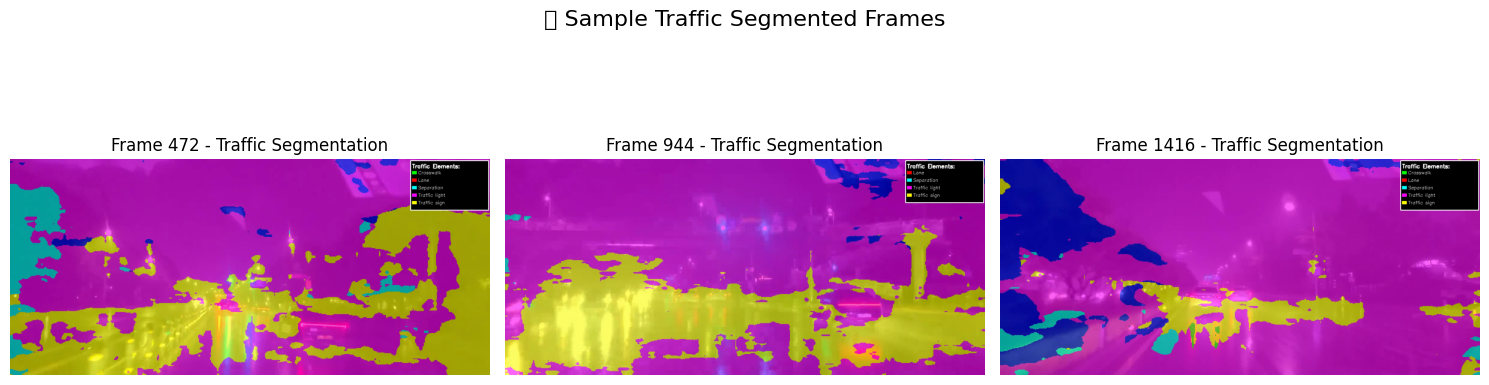


⬇️ Downloading KakaoTalk_20250716_203030552 (2)_traffic_segmented.mp4...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
# =============================================================================
# FIXED SEGFORMER VIDEO SEGMENTATION FOR TRAFFIC DATASET
# Upload video → Process with trained SegFormer → Download results
# =============================================================================

import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from PIL import Image
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from IPython.display import display, HTML, clear_output
from google.colab import files
import ipywidgets as widgets

# =============================================================================
# FIXED CONFIGURATION FOR YOUR TRAFFIC DATASET
# =============================================================================

CONFIG = {
    # FIXED: Path to your trained SegFormer model
    'model_path': './segformer_results/models/best_segformer.pth',  # Your saved model
    'base_model': 'nvidia/segformer-b2-finetuned-ade-512-512',    # Base pretrained model

    # FIXED: Your actual traffic class names
    'class_names': ['Background', 'Central line', 'Crosswalk', 'Lane',
                   'Separation', 'Traffic light', 'Traffic sign'],

    # Processing settings
    'max_size': 640,            # Processing resolution (640 for speed, 1024 for quality)
    'overlay_alpha': 0.6,       # Overlay transparency (0.0-1.0)
    'fps_output': 30,           # Output video FPS

    # FIXED: Colors for traffic classes (RGB)
    'colors': {
        0: [0, 0, 0],           # Background - black
        1: [255, 0, 0],         # Central line - red
        2: [0, 255, 0],         # Crosswalk - green
        3: [0, 0, 255],         # Lane - blue
        4: [255, 255, 0],       # Separation - yellow
        5: [255, 0, 255],       # Traffic light - magenta
        6: [0, 255, 255],       # Traffic sign - cyan
    }
}

print("🎯 SEGFORMER VIDEO SEGMENTATION - TRAFFIC DATASET VERSION")
print("=" * 60)

# =============================================================================
# FIXED MODEL LOADER CLASS
# =============================================================================

class SafeSegformerModel(nn.Module):
    """Safe wrapper for loading your trained SegFormer model with auto class detection"""

    def __init__(self, base_model_name: str, num_classes: int, model_path: str = None):
        super().__init__()
        self.num_classes = num_classes

        # Auto-detect number of classes from saved model if available
        if model_path and os.path.exists(model_path):
            try:
                print("🔍 Auto-detecting number of classes from saved model...")
                state_dict = torch.load(model_path, map_location='cpu')

                # Find classifier weight shape to determine actual number of classes
                classifier_key = None
                for key in state_dict.keys():
                    if 'classifier.weight' in key:
                        classifier_key = key
                        break

                if classifier_key:
                    actual_num_classes = state_dict[classifier_key].shape[0]
                    print(f"📊 Detected {actual_num_classes} classes in saved model")
                    self.num_classes = actual_num_classes
                else:
                    print("⚠️  Could not detect classes from model, using provided number")

            except Exception as e:
                print(f"⚠️  Error detecting classes: {e}, using provided number")

        # Load base model with detected/provided number of classes
        print(f"🏗️  Creating model with {self.num_classes} classes...")
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            base_model_name,
            num_labels=self.num_classes,
            ignore_mismatched_sizes=True
        )

    def forward(self, pixel_values):
        outputs = self.segformer(pixel_values=pixel_values)
        return outputs

# =============================================================================
# FIXED VIDEO PROCESSOR CLASS
# =============================================================================

class VideoSegFormer:
    def __init__(self, model_path, base_model, class_names, colors):
        self.model_path = model_path
        self.base_model = base_model
        self.original_class_names = class_names
        self.original_colors = colors
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

        print(f"🧠 Loading SegFormer model...")
        print(f"   Device: {self.device}")

        try:
            # FIXED: Load processor from base model
            self.processor = SegformerImageProcessor.from_pretrained(base_model)

            # FIXED: Auto-detect classes and load model
            initial_num_classes = len(class_names)
            self.model = SafeSegformerModel(base_model, initial_num_classes, model_path)
            self.num_classes = self.model.num_classes

            # Adjust class names and colors based on detected number
            self.class_names, self.colors = self._adjust_classes_and_colors()

            print(f"   Final classes: {self.num_classes}")
            print(f"   Class mapping: {self.class_names}")

            # FIXED: Load your trained weights if available
            if model_path and os.path.exists(model_path):
                print(f"📥 Loading trained weights from: {model_path}")
                state_dict = torch.load(model_path, map_location=self.device)

                # Try to load with strict=False to handle any remaining mismatches
                try:
                    self.model.load_state_dict(state_dict, strict=True)
                    print("✅ Trained weights loaded successfully (strict)!")
                except RuntimeError as e:
                    print(f"⚠️  Strict loading failed: {e}")
                    print("🔄 Trying flexible loading...")
                    self.model.load_state_dict(state_dict, strict=False)
                    print("✅ Trained weights loaded successfully (flexible)!")
            else:
                print(f"⚠️  Trained weights not found: {model_path}")
                print("🔄 Using base pretrained model...")

            self.model.to(self.device)
            self.model.eval()
            print("✅ Model ready for inference!")

        except Exception as e:
            print(f"❌ Model loading error: {e}")
            raise Exception(f"Failed to load model: {e}")

    def _adjust_classes_and_colors(self):
        """Adjust class names and colors based on detected number of classes"""

        if self.num_classes == len(self.original_class_names):
            # Perfect match
            return self.original_class_names, self.original_colors

        elif self.num_classes == len(self.original_class_names) - 1:
            # Likely missing background class
            print("🔄 Adjusting for model without background class...")
            adjusted_names = self.original_class_names[1:]  # Remove background
            adjusted_colors = {i: self.original_colors[i+1] for i in range(self.num_classes)}
            return adjusted_names, adjusted_colors

        else:
            # Custom adjustment
            print(f"🔄 Custom class adjustment: {self.num_classes} detected vs {len(self.original_class_names)} expected")

            # Use as many class names as we have
            if self.num_classes <= len(self.original_class_names):
                adjusted_names = self.original_class_names[:self.num_classes]
                adjusted_colors = {i: self.original_colors[i] for i in range(self.num_classes)}
            else:
                # More classes than names
                adjusted_names = self.original_class_names + [f"Class_{i}" for i in range(len(self.original_class_names), self.num_classes)]
                adjusted_colors = self.original_colors.copy()
                for i in range(len(self.original_colors), self.num_classes):
                    adjusted_colors[i] = [np.random.randint(0, 255) for _ in range(3)]

            return adjusted_names, adjusted_colors

    def segment_frame(self, frame):
        """Segment a single frame"""
        try:
            # Resize if needed
            original_h, original_w = frame.shape[:2]
            if max(original_h, original_w) > CONFIG['max_size']:
                scale = CONFIG['max_size'] / max(original_h, original_w)
                new_w, new_h = int(original_w * scale), int(original_h * scale)
                resized = cv2.resize(frame, (new_w, new_h))
            else:
                resized = frame
                scale = 1.0

            # Convert to RGB and process
            rgb = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)

            # FIXED: Process with your processor
            inputs = self.processor(rgb, return_tensors="pt")
            inputs = {k: v.to(self.device) for k, v in inputs.items()}

            with torch.no_grad():
                outputs = self.model(**inputs)
                logits = outputs.logits

                # FIXED: Proper upsampling and prediction
                upsampled_logits = nn.functional.interpolate(
                    logits,
                    size=rgb.shape[:2],
                    mode="bilinear",
                    align_corners=False,
                )
                prediction = upsampled_logits.argmax(dim=1)[0].cpu().numpy()

            # Resize back if needed
            if scale != 1.0:
                pred_pil = Image.fromarray(prediction.astype(np.uint8))
                pred_pil = pred_pil.resize((original_w, original_h), Image.NEAREST)
                prediction = np.array(pred_pil)

            return prediction

        except Exception as e:
            print(f"⚠️ Frame processing error: {e}")
            return np.zeros((frame.shape[0], frame.shape[1]), dtype=np.uint8)

    def create_overlay(self, frame, prediction):
        """Create colored overlay for traffic classes"""
        colored_mask = np.zeros_like(frame)

        for class_id, color in self.colors.items():
            if class_id > 0:  # Skip background
                mask = prediction == class_id
                colored_mask[mask] = color

        # Blend
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        overlay = cv2.addWeighted(frame_rgb, 1-CONFIG['overlay_alpha'],
                                 colored_mask, CONFIG['overlay_alpha'], 0)

        return cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR)

    def add_legend(self, frame, prediction):
        """Add legend showing detected traffic classes"""
        unique_classes = np.unique(prediction)

        # Handle different class indexing based on whether background is included
        if self.num_classes == len(self.original_class_names) - 1:
            # Model trained without background (classes 0-5 map to original 1-6)
            detected = [c for c in unique_classes if 0 <= c < len(self.class_names)]
        else:
            # Model includes background or has different structure
            detected = [c for c in unique_classes if c > 0 and c < len(self.class_names)]

        if not detected:
            return frame

        # Legend parameters
        legend_width = 250
        legend_height = 30 + len(detected) * 25
        x = frame.shape[1] - legend_width - 10
        y = 10

        # Background
        cv2.rectangle(frame, (x-5, y-5), (x+legend_width+5, y+legend_height+5),
                     (0, 0, 0), -1)
        cv2.rectangle(frame, (x-5, y-5), (x+legend_width+5, y+legend_height+5),
                     (255, 255, 255), 2)

        # Title
        cv2.putText(frame, "Traffic Elements:", (x, y+20), cv2.FONT_HERSHEY_SIMPLEX,
                   0.6, (255, 255, 255), 2)

        # Classes
        for i, class_id in enumerate(detected):
            y_pos = y + 40 + i * 25
            color = self.colors.get(class_id, [255, 255, 255])

            # Get class name based on indexing
            if class_id < len(self.class_names):
                class_name = self.class_names[class_id]
            else:
                class_name = f"Class{class_id}"

            # Color box
            cv2.rectangle(frame, (x, y_pos-10), (x+15, y_pos), color, -1)

            # Text
            cv2.putText(frame, class_name, (x+20, y_pos), cv2.FONT_HERSHEY_SIMPLEX,
                       0.5, (255, 255, 255), 1)

        return frame

# =============================================================================
# FIXED PROCESSING FUNCTIONS
# =============================================================================

def find_model_automatically():
    """Automatically find your trained model"""
    possible_paths = [
        './segformer_results/models/best_segformer.pth',
        './segformer_results/best_segformer.pth',
        './best_segformer.pth',
        './models/best_segformer.pth'
    ]

    for path in possible_paths:
        if os.path.exists(path):
            print(f"✅ Found model: {path}")
            return path

    print("⚠️  No trained model found. Will use base pretrained model.")
    return None

def process_video(input_file):
    """Process uploaded video with SegFormer"""

    # FIXED: Auto-find model
    model_path = find_model_automatically()
    if model_path:
        CONFIG['model_path'] = model_path

    try:
        # Initialize processor
        print("🚀 Initializing SegFormer...")
        segformer = VideoSegFormer(
            CONFIG['model_path'],
            CONFIG['base_model'],
            CONFIG['class_names'],
            CONFIG['colors']
        )

        # Open video
        cap = cv2.VideoCapture(input_file)
        if not cap.isOpened():
            print(f"❌ Cannot open video: {input_file}")
            return None

        # Get video info
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        print(f"📹 Video Info:")
        print(f"   Resolution: {width}x{height}")
        print(f"   FPS: {fps:.1f}")
        print(f"   Frames: {total_frames}")
        print(f"   Duration: {total_frames/fps:.1f}s")

        # Output file
        base_name = os.path.splitext(input_file)[0]
        output_file = f"{base_name}_traffic_segmented.mp4"
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_file, fourcc, CONFIG['fps_output'], (width, height))

        print(f"\n🔄 Processing video for traffic segmentation...")

        # Process frames
        frame_count = 0
        success_count = 0

        with tqdm(total=total_frames, desc="Segmenting frames") as pbar:
            while True:
                ret, frame = cap.read()
                if not ret:
                    break

                try:
                    # Segment frame
                    prediction = segformer.segment_frame(frame)

                    # Create overlay
                    overlay = segformer.create_overlay(frame, prediction)

                    # Add legend
                    final_frame = segformer.add_legend(overlay, prediction)

                    # Write frame
                    out.write(final_frame)
                    success_count += 1

                except Exception as e:
                    print(f"⚠️ Error in frame {frame_count}: {e}")
                    out.write(frame)  # Use original frame

                frame_count += 1
                pbar.update(1)

                # Update progress every 30 frames
                if frame_count % 30 == 0:
                    pbar.set_description(f"Segmenting frames - {success_count/frame_count*100:.1f}% success")

        # Cleanup
        cap.release()
        out.release()

        print(f"✅ Processing complete!")
        print(f"   Success rate: {success_count/total_frames*100:.1f}%")
        print(f"   Output: {output_file}")

        return output_file

    except Exception as e:
        print(f"❌ Processing failed: {e}")
        import traceback
        traceback.print_exc()
        return None

def show_sample_frames(video_file, num_samples=3):
    """Show sample frames from processed video"""
    try:
        cap = cv2.VideoCapture(video_file)
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Get sample frames
        frames = []
        indices = [total_frames//4, total_frames//2, 3*total_frames//4]

        for idx in indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
            ret, frame = cap.read()
            if ret:
                frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        cap.release()

        if frames:
            fig, axes = plt.subplots(1, len(frames), figsize=(15, 5))
            if len(frames) == 1:
                axes = [axes]

            for i, frame in enumerate(frames):
                axes[i].imshow(frame)
                axes[i].set_title(f"Frame {indices[i]} - Traffic Segmentation")
                axes[i].axis('off')

            plt.suptitle("🚗 Sample Traffic Segmented Frames", fontsize=16)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"⚠️ Cannot show samples: {e}")

# =============================================================================
# FIXED INTERFACE
# =============================================================================

def upload_and_segment_traffic():
    """Simple function to upload and segment traffic video"""
    print("🚗 UPLOAD AND SEGMENT TRAFFIC VIDEO")
    print("=" * 40)

    # Auto-find model
    model_path = find_model_automatically()

    if model_path:
        print(f"✅ Using trained model: {model_path}")
    else:
        print("⚠️  No trained model found, using base pretrained model")
        print("💡 The model will still work but might not be optimal for your specific traffic dataset")

    print(f"🎯 Traffic classes: {', '.join(CONFIG['class_names'])}")

    # Upload
    print("\n📁 Select your video file:")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded!")
        return

    filename = list(uploaded.keys())[0]
    print(f"✅ Processing {filename} for traffic segmentation...")

    # Process
    output_file = process_video(filename)

    if output_file:
        print(f"\n🎉 Complete! Traffic segmentation finished!")
        print(f"📊 File size: {os.path.getsize(output_file)/1024/1024:.1f} MB")

        # Show sample frames
        show_sample_frames(output_file)

        print(f"\n⬇️ Downloading {output_file}...")
        files.download(output_file)
    else:
        print("❌ Processing failed!")

# =============================================================================
# STATUS CHECK AND AUTO-START
# =============================================================================

def check_setup():
    """Check if everything is ready"""
    print("⚙️ SETUP STATUS CHECK")
    print("=" * 30)

    # Check model and auto-detect classes
    model_path = find_model_automatically()
    if model_path:
        print(f"✅ Model: {model_path}")

        # Try to detect actual number of classes
        try:
            state_dict = torch.load(model_path, map_location='cpu')
            classifier_key = None
            for key in state_dict.keys():
                if 'classifier.weight' in key:
                    classifier_key = key
                    break

            if classifier_key:
                actual_num_classes = state_dict[classifier_key].shape[0]
                print(f"📊 Detected classes: {actual_num_classes}")

                if actual_num_classes == 6:
                    print("🔄 Model trained with 6 classes (likely without background)")
                    adjusted_classes = CONFIG['class_names'][1:]  # Remove background
                    print(f"📝 Adjusted class list: {adjusted_classes}")
                elif actual_num_classes == 7:
                    print(f"📝 Model classes: {CONFIG['class_names']}")
                else:
                    print(f"⚠️  Custom class count: {actual_num_classes}")

        except Exception as e:
            print(f"⚠️  Could not detect classes: {e}")
    else:
        print("⚠️  Model: Using base pretrained model")

    # Check device
    device = 'GPU' if torch.cuda.is_available() else 'CPU'
    print(f"✅ Device: {device}")

    print("\n🚀 Ready to process traffic videos!")
    print("=" * 30)

# Run setup check
check_setup()

print("\n" + "="*60)
print("🚗 HOW TO USE FOR TRAFFIC SEGMENTATION:")
print("="*60)
print(">>> upload_and_segment_traffic()")
print("="*60)

# Auto-start
print("\n🎯 Starting traffic video segmentation interface...")
upload_and_segment_traffic()